### Overview 
First, we generate the fishnets in the study area.We extracted fishnets that intersected with lakes and 1/10 no-lake fishnet as the training areas.

These already labeled lakes will be used as training polygons.

Secondly, we determine the training area for each training polygon and generate a weighted boundary for each training area. 

Then, we read the raw satellite images (pan channel).from each satellite image, we extract areas that overlap with a training area. The part of the pan image that overlap with the training area and the corresponding label/annotation and boundary weights are then written to separate files.

Four images' training areas overlap with each other.In order to avoid conflict, we need to execute the preprocessing script four times.

Here, the term training area and training polygon represent all available input data, which can then be separated into training, validation, and test sets in the next notebook(s). 

In [287]:
import sys
print(sys.version)
print(sys.executable)

3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)]
D:\Software\anaconda\envs\acmtensorflow\python.exe


In [288]:
import rasterio                  # I/O raster data (netcdf, height, geotiff, ...)
import rasterio.mask
import rasterio.warp             # Reproject raster samples
import rasterio.merge
from rasterio.transform import rowcol
from rasterio.transform import from_origin
import fiona                     # I/O vector data (shape, geojson, ...)
import pyproj                    # Change coordinate reference system
import geopandas as gps
import pandas as pd
import shapely
from shapely.geometry import box, Point
import json

import numpy as np               # numerical array manipulation
import time
import os
from PIL import Image
import PIL.ImageDraw
from core.visualize import display_images
from core.frame_info import image_normalize

import matplotlib.pyplot as plt  # plotting tools
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")

from shapely.geometry import Polygon

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

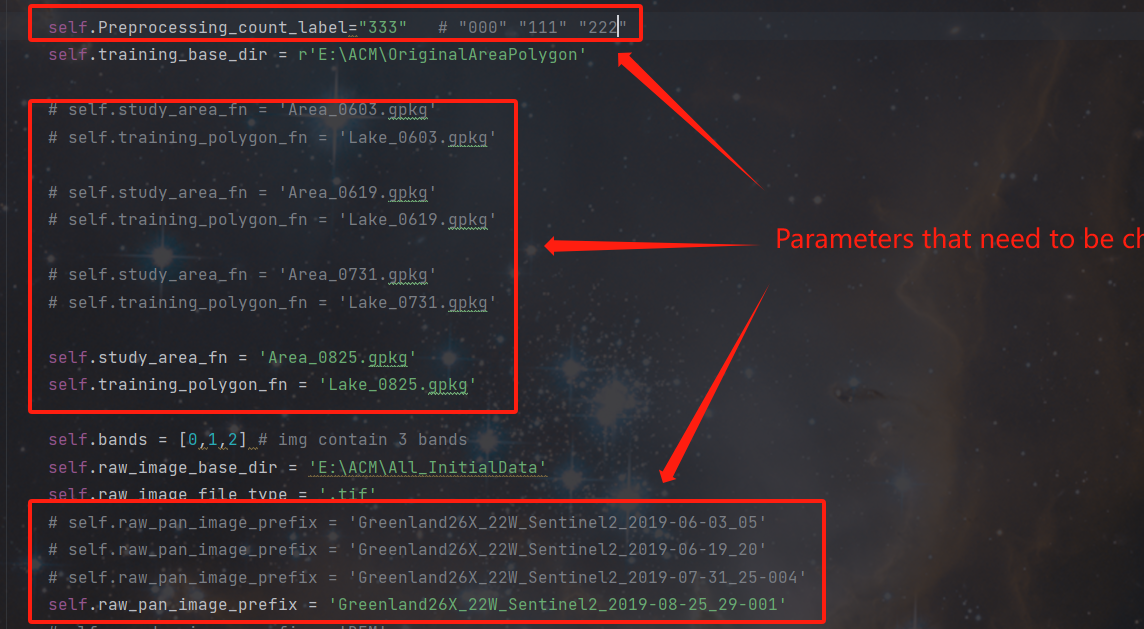
Four images'training areas overlap with each other.In order to avoid conflict, we need to execute the preprocessing script four times.
Note that each time the preprocessing script is executed, the input vector, the image and ‘Preprocessing_count_label’ parameter need to be changed; ‘Preprocessing_count_label’ serves as a naming distinction for the data output.

In [289]:
# Required configurations (including the input and output paths) are stored in a separate file (such as config/Preprocessing.py)
# Please provide required info in the file before continuing with this notebook. 
 
from config import Preprocessing
config = Preprocessing.Configuration()
print(config.raw_image_base_dir)

D:\SelfStudy\ACM_contest2023\All_TraningData_Prepare\Image


In [290]:
#Read the training area and training polygons
StudyArea = gps.read_file(os.path.join(config.training_base_dir, config.study_area_fn))
trainingPolygon = gps.read_file(os.path.join(config.training_base_dir, config.training_polygon_fn))

print(f'Read a total of {trainingPolygon.shape[0]} object polygons and {StudyArea.shape[0]} Study areas.')
print(f'Polygons will be assigned to training areas in the next steps.')

Read a total of 311 object polygons and 3 Study areas.
Polygons will be assigned to training areas in the next steps.


In [291]:
print(trainingPolygon.crs)
print(StudyArea.crs)

epsg:3857
epsg:3857


In [292]:
#generate fishnet
def Generate_Fishnet(boundary,cell_height,cell_width):
    xmin, ymin, xmax, ymax = boundary.total_bounds
    rows = int((ymax - ymin) / cell_height)
    print(rows)
    cols = int((xmax - xmin) / cell_width)
    print(cols)
    targetCRS = boundary.crs
    polygons = []
    print(rows)
    print(cols)
    for x in range(cols):
        for y in range(rows):
            polygons.append(Polygon([(xmin + x * cell_width, ymin + y * cell_height),
                                    (xmin + (x + 1) * cell_width, ymin + y * cell_height),
                                    (xmin + (x + 1) * cell_width, ymin + (y + 1) * cell_height),
                                    (xmin + x * cell_width, ymin + (y + 1) * cell_height)]))
    fishnet = gps.GeoDataFrame(geometry=polygons, crs=boundary.crs)
    fishnet=fishnet["geometry"]

    fishnet = fishnet.to_crs(targetCRS)
    return fishnet

In [293]:
Fishnet=Generate_Fishnet(StudyArea,19550,19550)
Fishnet.to_file(config.fishnet_base_dir+r'\\Generate_Fishnet.shp')
Fishnet_Inter = Fishnet[Fishnet.intersects(StudyArea.unary_union)]
Fishnet_Inter = gps.GeoDataFrame({'geometry': Fishnet_Inter})
Fishnet_Inter['id'] = range(Fishnet_Inter.shape[0])
Fishnet_Inter.to_file(config.fishnet_base_dir+r'\\Generate_Fishnet_Inter.shp')

294
169
294
169


In [294]:
Fishnet_Inter_with_Poly = gps.sjoin(Fishnet_Inter,trainingPolygon, how='inner', op='intersects')

Fishnet_Inter_with_Poly

,geometry,id,index_right,image,region_num
2368,"POLYGON ((-5521609.204 10194150.732, -5502059....",167,87,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,3
2647,"POLYGON ((-5502059.204 9900900.732, -5482509.2...",180,125,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,3
2649,"POLYGON ((-5502059.204 9940000.732, -5482509.2...",182,122,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,3
2651,"POLYGON ((-5502059.204 9979100.732, -5482509.2...",184,118,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,3
2946,"POLYGON ((-5482509.204 9998650.732, -5462959.2...",215,112,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,3
...,...,...,...,...,...
48761,"POLYGON ((-2452259.204 14788400.732, -2432709....",3198,300,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,5
48767,"POLYGON ((-2452259.204 14905700.732, -2432709....",3204,279,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,5
49061,"POLYGON ((-2432709.204 14905700.732, -2413159....",3243,279,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,5
48770,"POLYGON ((-2452259.204 14964350.732, -2432709....",3207,266,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,5


In [295]:
Fishnet_Inter_with_Poly = Fishnet_Inter_with_Poly.dissolve(by = 'id')


duplicates = Fishnet_Inter_with_Poly.columns[Fishnet_Inter_with_Poly.columns.duplicated(keep='first')]
Fishnet_Inter_with_Poly = Fishnet_Inter_with_Poly.drop(columns=duplicates)
Fishnet_Inter_with_Poly.to_file(config.fishnet_base_dir+r'\\Generate_Fishnet_Interr_with_Poly.shp')

spatial_join = gps.sjoin(Fishnet_Inter, trainingPolygon, how='left', op='intersects')

Fishnet_Inter_without_Poly = spatial_join[spatial_join['index_right'].isnull()]
Fishnet_Inter_without_Poly.to_file(config.fishnet_base_dir+r'\\Generate_Fishnet_Inter_without_Poly.shp')
print(len(Fishnet_Inter_with_Poly))
sample_size = len(Fishnet_Inter_with_Poly) // 7 + 10
print(sample_size)
Fishnet_Inter_without_Poly_sample = Fishnet_Inter_without_Poly.sample(n=sample_size, random_state=42)
Fishnet_Inter_without_Poly_sample.to_file(config.fishnet_base_dir+r'\\Generate_Fishnet_Inter_without_Poly_sample.shp')

Fishnet_TraininigPart = Fishnet_Inter_with_Poly.append(Fishnet_Inter_without_Poly_sample, ignore_index=True)
Fishnet_TraininigPart.to_file(config.fishnet_base_dir+r'\\Generate_Fishnet_TrainingPart.shp')

trainingArea=Fishnet_TraininigPart
trainingArea

391
65


,geometry,index_right,image,region_num,id
0,"POLYGON ((-5521609.204 10194150.732, -5502059....",87.0,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,3.0,NaN
1,"POLYGON ((-5502059.204 9900900.732, -5482509.2...",125.0,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,3.0,NaN
2,"POLYGON ((-5502059.204 9940000.732, -5482509.2...",122.0,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,3.0,NaN
3,"POLYGON ((-5502059.204 9979100.732, -5482509.2...",118.0,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,3.0,NaN
4,"POLYGON ((-5482509.204 9998650.732, -5462959.2...",112.0,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,3.0,NaN
...,...,...,...,...,...
451,"POLYGON ((-3195159.204 15101200.732, -3175609....",NaN,NaN,NaN,1490.0
452,"POLYGON ((-2647759.204 15277150.732, -2628209....",NaN,NaN,NaN,2762.0
453,"POLYGON ((-3429759.204 15374900.732, -3410209....",NaN,NaN,NaN,1068.0
454,"POLYGON ((-5326109.204 9920450.732, -5306559.2...",NaN,NaN,NaN,493.0


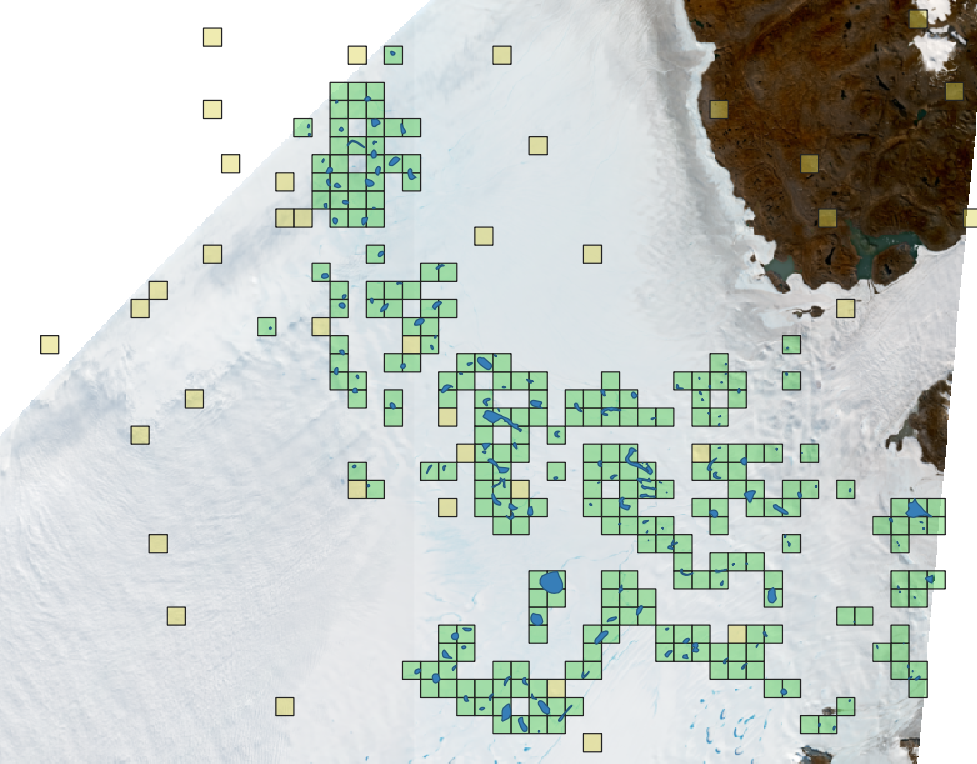
Extracted fishing nets that intersected with lakes as the training areas.（GreenPart） 
The rest of the no-lake fishnet area we will take GreenPart 1/7th  into the training areas to ensure that the training set covers more situations.（YellowPart）

In [296]:
#Check if the training areas and the training polygons have the same crs
if trainingArea.crs  != trainingPolygon.crs:
    print('Training area CRS does not match training_polygon CRS')
    targetCRS = trainingPolygon.crs #Areas are less in number so conversion should be faster
    trainingArea = trainingArea.to_crs(targetCRS)
print(trainingPolygon.crs)
print(trainingArea.crs)
assert trainingPolygon.crs == trainingArea.crs
trainingPolygon['id'] = range(trainingPolygon.shape[0])
trainingPolygon

epsg:3857
epsg:3857


,image,region_num,geometry,id
0,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,1,"POLYGON ((-5394046.431 10742765.703, -5394313....",0
1,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,1,"POLYGON ((-5459208.997 10599293.401, -5459247....",1
2,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,1,"POLYGON ((-5440367.270 10626275.672, -5440443....",2
3,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,1,"POLYGON ((-5392861.657 10789086.542, -5392899....",3
4,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,1,"POLYGON ((-5386708.476 10852299.965, -5386708....",4
...,...,...,...,...
306,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,5,"POLYGON ((-2522995.211 14778908.326, -2522956....",306
307,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,5,"POLYGON ((-2930022.387 14770423.816, -2929754....",307
308,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,5,"POLYGON ((-2830845.343 14772908.020, -2830768....",308
309,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,5,"POLYGON ((-2885421.381 14759569.758, -2884962....",309


In [297]:
# Assign serial IDs to training areas
trainingArea['id'] = range(trainingArea.shape[0])
trainingArea

,geometry,index_right,image,region_num,id
0,"POLYGON ((-5521609.204 10194150.732, -5502059....",87.0,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,3.0,0
1,"POLYGON ((-5502059.204 9900900.732, -5482509.2...",125.0,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,3.0,1
2,"POLYGON ((-5502059.204 9940000.732, -5482509.2...",122.0,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,3.0,2
3,"POLYGON ((-5502059.204 9979100.732, -5482509.2...",118.0,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,3.0,3
4,"POLYGON ((-5482509.204 9998650.732, -5462959.2...",112.0,Greenland26X_22W_Sentinel2_2019-08-25_29.tif,3.0,4
...,...,...,...,...,...
451,"POLYGON ((-3195159.204 15101200.732, -3175609....",NaN,NaN,NaN,451
452,"POLYGON ((-2647759.204 15277150.732, -2628209....",NaN,NaN,NaN,452
453,"POLYGON ((-3429759.204 15374900.732, -3410209....",NaN,NaN,NaN,453
454,"POLYGON ((-5326109.204 9920450.732, -5306559.2...",NaN,NaN,NaN,454


In [298]:
# Create boundary from polygon file
def calculateBoundaryWeight(CRS,polygonsInArea, scale_polygon = 1.5, output_plot = True): 
    '''
    For each polygon, create a weighted boundary where the weights of shared/close boundaries is higher than weights of solitary boundaries.
    '''
    # If there are polygons in a area, the boundary polygons return an empty geo dataframe
    if not polygonsInArea:
        return gps.GeoDataFrame({})
    tempPolygonDf = pd.DataFrame(polygonsInArea)
    tempPolygonDf.reset_index(drop=True,inplace=True)
    tempPolygonDf = gps.GeoDataFrame(tempPolygonDf.drop(columns=['id']))
    tempPolygonDf=tempPolygonDf.set_crs(CRS)
    #tempPolygonDf.to_crs(CRS)
    tempPolygonDf=tempPolygonDf.set_geometry('geometry')

    #print(CRS)
    print(tempPolygonDf.crs)
    types = tempPolygonDf.dtypes
    new_c = []
    #for each polygon in area scale, compare with other polygons:
    for i in tqdm(range(len(tempPolygonDf))):
        pol1 = gps.GeoSeries(tempPolygonDf['geometry'])  # gdf['geometry'] (tempPolygonDf.iloc[i][2])
        sc = pol1.scale(xfact=scale_polygon, yfact=scale_polygon, zfact=scale_polygon, origin='center') #Sscle
        scc = pd.DataFrame(columns=['id', 'geometry'])
        scc = scc.append({'id': None, 'geometry': sc[0]}, ignore_index=True)
        scc = gps.GeoDataFrame(pd.concat([scc]*len(tempPolygonDf), ignore_index=True))
        scc=scc.set_geometry('geometry')
        pol2 = gps.GeoDataFrame(tempPolygonDf[~tempPolygonDf.index.isin([i])])
        #scale pol2 also and then intersect, so in the end no need for scale
        pol2 = gps.GeoDataFrame(pol2.scale(xfact=scale_polygon, yfact=scale_polygon, zfact=scale_polygon, origin='center'))
        pol2.columns = ['geometry']
        pol2=pol2.set_geometry('geometry')
        ints = scc.intersection(pol2)
        for k in range(len(ints)):
            if ints.iloc[k]!=None:
                if ints.iloc[k].is_empty !=1:
                    new_c.append(ints.iloc[k])
    new_c = gps.GeoSeries(new_c)
    new_cc = gps.GeoDataFrame({'geometry': new_c})
    new_cc.columns = ['geometry']
    try:
        bounda = gps.overlay(new_cc, tempPolygonDf, how='difference')
        if output_plot:
            fig, ax = plt.subplots(figsize = (10,10))
            bounda.plot(ax=ax,color = 'red')
            plt.show()
        #change multipolygon to polygon
        bounda = bounda.explode()
        bounda.reset_index(drop=True,inplace=True)
        return bounda 
    except:
        return None

In [299]:
# As input we received two shapefile, first one contains the training fishnet areas and other contains the polygon of lakes in those training areas
# The first task is to determine the parent training area for each polygon and generate a weight map based upon the distance of a polygon boundary to other objects.
# Weight map will be used by the weighted loss during the U-Net training

def dividePolygonsInTrainingAreas(trainingPolygon, trainingArea):
    '''
    Assign annotated ploygons in to the training areas.
    '''
    cpTrainingPolygon = trainingPolygon.copy()
    splitPolygons = {}
    print("length cpTrainingPolygon.index  " +str(len(cpTrainingPolygon.index)))
    print(len(trainingArea.index))
    print(len(cpTrainingPolygon.index))
    for i in tqdm(trainingArea.index):
        spTemp = []
        allocated = []
        #spTemp_bound = []
        for j in cpTrainingPolygon.index: 
            if trainingArea.loc[i]['geometry'].intersects(cpTrainingPolygon.loc[j]['geometry']):
                print("trainingArea "+str(i) +" intersects with "+ " TrainingPolygon "+str(j))
                spTemp.append(cpTrainingPolygon.loc[j])
                allocated.append(j)
            # Order of bounds: minx miny maxx maxy
        CRS=trainingArea.crs
        boundary = calculateBoundaryWeight(CRS,spTemp, scale_polygon = 2, output_plot = config.show_boundaries_during_processing)
        splitPolygons[trainingArea.loc[i]['id']] = {'polygons':spTemp, 'boundaryWeight': boundary, 'bounds':list(trainingArea.bounds.loc[i]),}
        print(splitPolygons[trainingArea.loc[i]['id']])
        #cpTrainingPolygon = cpTrainingPolygon.drop(allocated)
    return splitPolygons

# areasWithPolygons contains the object polygons and weighted boundaries for each area!
areasWithPolygons = dividePolygonsInTrainingAreas(trainingPolygon, trainingArea)
print(f'Assigned training polygons in {len(areasWithPolygons)} training areas and created weighted boundaries for ploygons')

length cpTrainingPolygon.index  311
456
311


  0%|          | 0/456 [00:00<?, ?it/s]

trainingArea 0 intersects with  TrainingPolygon 87
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5505071.214126652 10203578.90578814...
id                                                           87
Name: 87, dtype: object], 'boundaryWeight': None, 'bounds': [-5521609.203512804, 10194150.731596973, -5502059.203512804, 10213700.731596973]}
trainingArea 1 intersects with  TrainingPolygon 125
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5496128.081817287 9919424.253138006...
id                                                          125
Name: 125, dtype: object], 'boundaryWeight': None, 'bounds': [-5502059.203512804, 9900900.731596973, -5482509.203512804, 9920450.731596973]}
trainingArea 2 intersects with  TrainingPolygon 122
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5488484.378988769 9956954.834026027...
id                                                          122
Name: 122, dtype: object], 'boundaryWeight': None, 'bounds': [-5502059.203512804, 9940000.731596973, -5482509.203512804, 9959550.731596973]}
trainingArea 3 intersects with  TrainingPolygon 118
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5495287.27450615 9983058.079185415,...
id                                                          118
Name: 118, dtype: object], 'boundaryWeight': None, 'bounds': [-5502059.203512804, 9979100.731596973, -5482509.203512804, 9998650.731596973]}
trainingArea 4 intersects with  TrainingPolygon 112
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5474802.150925723 10017148.99380060...
id                                                          112
Name: 112, dtype: object], 'boundaryWeight': None, 'bounds': [-5482509.203512804, 9998650.731596973, -5462959.203512804, 10018200.731596973]}
trainingArea 5 intersects with  TrainingPolygon 92
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5468496.096092195 10178431.12348232...
id                                                           92
Name: 92, dtype: object], 'boundaryWeight': None, 'bounds': [-5482509.203512804, 10174600.731596973, -5462959.203512804, 10194150.731596973]}
trainingArea 6 intersects with  TrainingPolygon 124
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5459973.367438398 9955999.371172462...
id                                                          124
Name: 124, dtype: object], 'boundaryWeight': None, 'bounds': [-5462959.203512804, 9940000.731596973, -5443409.203512804, 9959550.731596973]}
trainingArea 7 intersects with  TrainingPolygon 119
trainingArea 7 intersects with  TrainingPolygon 121
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5456266.171566567 9979083.353714585...
id                                                          119
Name: 119, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5459591.182296973 9970254.876947649...
id                                                          121
Name: 121, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5455941.314 9979350.883, -5455864.8..., 'bounds': [-5462959.203512804, 9959550.731596973, -5443409.203512804, 9979100.731596973]}
trainingArea 8 intersects with  TrainingPolygon 113
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5451756.386897742 10016193.53094703...
id                                                          113
Name: 113, dtype: object], 'boundaryWeight': None, 'bounds': [-5462959.203512804, 9998650.731596973, -5443409.203512804, 10018200.731596973]}
trainingArea 9 intersects with  TrainingPolygon 106
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5449539.713077472 10081852.93824400...
id                                                          106
Name: 106, dtype: object], 'boundaryWeight': None, 'bounds': [-5462959.203512804, 10076850.731596973, -5443409.203512804, 10096400.731596973]}
trainingArea 10 intersects with  TrainingPolygon 76
trainingArea 10 intersects with  TrainingPolygon 77
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5451144.890671461 10111548.72373279...
id                                                           76
Name: 76, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5449807.24267647 10112848.153213643...
id                                                           77
Name: 77, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5450781.815 10112733.498, -5450705....
1  POLYGON ((-5451011.126 10112848.153, -5451030....
2  POLYGON ((-5451316.874 10111204.757, -5451393...., 'bounds': [-5462959.203512804, 10096400.731596973, -5443409.203512804, 10115950.731596973]}
trainingArea 11 intersects with  TrainingPolygon 101
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5458559.282415123 10138607.43174574...
id                                                          101
Name: 101, dtype: object], 'boundaryWeight': None, 'bounds': [-5462959.203512804, 10135500.731596973, -5443409.203512804, 10155050.731596973]}
trainingArea 12 intersects with  TrainingPolygon 89
trainingArea 12 intersects with  TrainingPolygon 91
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5457221.634420132 10191731.16640394...
id                                                           89
Name: 89, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5449883.679704756 10186151.26333912...
id                                                           91
Name: 91, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5456170.625 10192113.352, -5456094...., 'bounds': [-5462959.203512804, 10174600.731596973, -5443409.203512804, 10194150.731596973]}
trainingArea 13 intersects with  TrainingPolygon 82
trainingArea 13 intersects with  TrainingPolygon 83
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5454278.8088311525 10226242.4846747...
id                                                           82
Name: 82, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5447437.69479963 10226433.577245414...
id                                                           83
Name: 83, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5454183.263 10226892.199, -5454106...., 'bounds': [-5462959.203512804, 10213700.731596973, -5443409.203512804, 10233250.731596973]}
trainingArea 14 intersects with  TrainingPolygon 21
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5457794.912132271 10583700.24745033...
id                                                           21
Name: 21, dtype: object], 'boundaryWeight': None, 'bounds': [-5462959.203512804, 10565600.731596973, -5443409.203512804, 10585150.731596973]}
trainingArea 15 intersects with  TrainingPolygon 1
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5459208.997155547 10599293.40122050...
id                                                            1
Name: 1, dtype: object], 'boundaryWeight': None, 'bounds': [-5462959.203512804, 10585150.731596973, -5443409.203512804, 10604700.731596973]}
trainingArea 16 intersects with  TrainingPolygon 1
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5459208.997155547 10599293.40122050...
id                                                            1
Name: 1, dtype: object], 'boundaryWeight': None, 'bounds': [-5462959.203512804, 10604700.731596973, -5443409.203512804, 10624250.731596973]}
trainingArea 17 intersects with  TrainingPolygon 126
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5433258.62605273 9917933.731086444,...
id                                                          126
Name: 126, dtype: object], 'boundaryWeight': None, 'bounds': [-5443409.203512804, 9900900.731596973, -5423859.203512804, 9920450.731596973]}
trainingArea 18 intersects with  TrainingPolygon 74
trainingArea 18 intersects with  TrainingPolygon 123
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5428519.530299049 9944457.379901402...
id                                                           74
Name: 74, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5434022.996335581 9956534.430370457...
id                                                          123
Name: 123, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5429704.304 9942947.749, -5429780.7..., 'bounds': [-5443409.203512804, 9940000.731596973, -5423859.203512804, 9959550.731596973]}
trainingArea 19 intersects with  TrainingPolygon 117
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5425997.108365637 9984281.071637977...
id                                                          117
Name: 117, dtype: object], 'boundaryWeight': None, 'bounds': [-5443409.203512804, 9979100.731596973, -5423859.203512804, 9998650.731596973]}
trainingArea 20 intersects with  TrainingPolygon 114
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5440061.52157011 10010155.00571251,...
id                                                          114
Name: 114, dtype: object], 'boundaryWeight': None, 'bounds': [-5443409.203512804, 9998650.731596973, -5423859.203512804, 10018200.731596973]}
trainingArea 21 intersects with  TrainingPolygon 78
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5430583.330062748 10044284.13884184...
id                                                           78
Name: 78, dtype: object], 'boundaryWeight': None, 'bounds': [-5443409.203512804, 10037750.731596973, -5423859.203512804, 10057300.731596973]}
trainingArea 22 intersects with  TrainingPolygon 93
trainingArea 22 intersects with  TrainingPolygon 94
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5441322.732536815 10164557.80284856...
id                                                           93
Name: 93, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5442010.665791382 10164481.36582028...
id                                                           94
Name: 94, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5441494.716 10164691.568, -5441437....
1  POLYGON ((-5441188.968 10164806.223, -5441188...., 'bounds': [-5443409.203512804, 10155050.731596973, -5423859.203512804, 10174600.731596973]}
trainingArea 23 intersects with  TrainingPolygon 2
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5440367.269683251 10626275.67220517...
id                                                            2
Name: 2, dtype: object], 'boundaryWeight': None, 'bounds': [-5443409.203512804, 10624250.731596973, -5423859.203512804, 10643800.731596973]}
trainingArea 24 intersects with  TrainingPolygon 53
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5426149.982422208 10681233.89554221...
id                                                           53
Name: 53, dtype: object], 'boundaryWeight': None, 'bounds': [-5443409.203512804, 10663350.731596973, -5423859.203512804, 10682900.731596973]}
trainingArea 25 intersects with  TrainingPolygon 120
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5419385.30541897 9973121.265508343,...
id                                                          120
Name: 120, dtype: object], 'boundaryWeight': None, 'bounds': [-5423859.203512804, 9959550.731596973, -5404309.203512804, 9979100.731596973]}
trainingArea 26 intersects with  TrainingPolygon 110
trainingArea 26 intersects with  TrainingPolygon 111
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5406811.414266058 10026741.84085039...
id                                                          110
Name: 110, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5405397.329242783 10022805.33389370...
id                                                          111
Name: 111, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5406123.481 10027085.807, -5405970....
1  POLYGON ((-5406582.103 10026397.874, -5406658....
2  POLYGON ((-5407117.162 10026397.874, -5407117....
3  POLYGON ((-5407652.222 10026627.185, -5407652...., 'bounds': [-5423859.203512804, 10018200.731596973, -5404309.203512804, 10037750.731596973]}
trainingArea 27 intersects with  TrainingPoly

  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5421219.794097814 10047494.49402981...
id                                                           79
Name: 79, dtype: object], 'boundaryWeight': None, 'bounds': [-5423859.203512804, 10037750.731596973, -5404309.203512804, 10057300.731596973]}
trainingArea 28 intersects with  TrainingPolygon 108
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5409028.0880863285 10085942.3192572...
id                                                          108
Name: 108, dtype: object], 'boundaryWeight': None, 'bounds': [-5423859.203512804, 10057300.731596973, -5404309.203512804, 10076850.731596973]}
trainingArea 29 intersects with  TrainingPolygon 107
trainingArea 29 intersects with  TrainingPolygon 108
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5404785.833016502 10081165.00498943...
id                                                          107
Name: 107, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5409028.0880863285 10085942.3192572...
id                                                          108
Name: 108, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5405416.438 10082254.233, -5405416....
1  POLYGON ((-5405416.438 10082177.796, -5405263...., 'bounds': [-5423859.203512804, 10076850.731596973, -5404309.203512804, 10096400.731596973]}
trainingArea 30 intersects with  TrainingPolygon 103
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5423168.938319086 10135549.95061434...
id                                                          103
Name: 103, dtype: object], 'boundaryWeight': None, 'bounds': [-5423859.203512804, 10115950.731596973, -5404309.203512804, 10135500.731596973]}
trainingArea 31 intersects with  TrainingPolygon 96
trainingArea 31 intersects with  TrainingPolygon 98
trainingArea 31 intersects with  TrainingPolygon 99
trainingArea 31 intersects with  TrainingPolygon 100
trainingArea 31 intersects with  TrainingPolygon 102
trainingArea 31 intersects with  TrainingPolygon 103
epsg:3857


  0%|          | 0/6 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5423207.156833229 10155652.88905334...
id                                                           96
Name: 96, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5414111.150467292 10152901.15603507...
id                                                           98
Name: 98, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5405397.329242783 10144263.77183885...
id                                                           99
Name: 99, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      P

  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5413308.561670299 10162226.47348586...
id                                                           95
Name: 95, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5423207.156833229 10155652.88905334...
id                                                           96
Name: 96, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5413021.923 10162685.096, -5412869...., 'bounds': [-5423859.203512804, 10155050.731596973, -5404309.203512804, 10174600.731596973]}
trainingArea 33 intersects with  TrainingPolygon 88
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5403677.496106367 10203349.59470329...
id                                                           88
Name: 88, dtype: object], 'boundaryWeight': None, 'bounds': [-5423859.203512804, 10194150.731596973, -5404309.203512804, 10213700.731596973]}
trainingArea 34 intersects with  TrainingPolygon 81
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5412238.443274306 10226013.17358984...
id                                                           81
Name: 81, dtype: object], 'boundaryWeight': None, 'bounds': [-5423859.203512804, 10213700.731596973, -5404309.203512804, 10233250.731596973]}
trainingArea 35 intersects with  TrainingPolygon 115
trainingArea 35 intersects with  TrainingPolygon 116
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5400658.233489102 9997046.055361602...
id                                                          115
Name: 115, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5397180.348702126 9995975.936965609...
id                                                          116
Name: 116, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5398212.249 9996453.668, -5398288.6...
1  POLYGON ((-5400658.233 9997294.476, -5400581.7...
2  POLYGON ((-5400581.796 9996682.979, -5400581.7..., 'bounds': [-5404309.203512804, 9979100.731596973, -5384759.203512804, 9998650.731596973]}
trainingArea 36 intersects with  TrainingPolygon 109
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5396301.322876846 10047609.14957224...
id                                                          109
Name: 109, dtype: object], 'boundaryWeight': None, 'bounds': [-5404309.203512804, 10037750.731596973, -5384759.203512804, 10057300.731596973]}
trainingArea 37 intersects with  TrainingPolygon 108
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5409028.0880863285 10085942.3192572...
id                                                          108
Name: 108, dtype: object], 'boundaryWeight': None, 'bounds': [-5404309.203512804, 10057300.731596973, -5384759.203512804, 10076850.731596973]}
trainingArea 38 intersects with  TrainingPolygon 80
trainingArea 38 intersects with  TrainingPolygon 107
trainingArea 38 intersects with  TrainingPolygon 108
epsg:3857


  0%|          | 0/3 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5393549.58985858 10084681.108290557...
id                                                           80
Name: 80, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5404785.833016502 10081165.00498943...
id                                                          107
Name: 107, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5409028.0880863285 10085942.3192572...
id                                                          108
Name: 108, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5393262.951 10085502.806, -5393262....
1  POLYGON ((-53

  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5393320.278773725 10113230.33835506...
id                                                           75
Name: 75, dtype: object], 'boundaryWeight': None, 'bounds': [-5404309.203512804, 10096400.731596973, -5384759.203512804, 10115950.731596973]}
trainingArea 40 intersects with  TrainingPolygon 105
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5384759.3316057855 10123396.4631169...
id                                                          105
Name: 105, dtype: object], 'boundaryWeight': None, 'bounds': [-5404309.203512804, 10115950.731596973, -5384759.203512804, 10135500.731596973]}
trainingArea 41 intersects with  TrainingPolygon 102
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5403868.588677079 10140021.51676902...
id                                                          102
Name: 102, dtype: object], 'boundaryWeight': None, 'bounds': [-5404309.203512804, 10135500.731596973, -5384759.203512804, 10155050.731596973]}
trainingArea 42 intersects with  TrainingPolygon 88
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5403677.496106367 10203349.59470329...
id                                                           88
Name: 88, dtype: object], 'boundaryWeight': None, 'bounds': [-5404309.203512804, 10194150.731596973, -5384759.203512804, 10213700.731596973]}
trainingArea 43 intersects with  TrainingPolygon 70
trainingArea 43 intersects with  TrainingPolygon 71
trainingArea 43 intersects with  TrainingPolygon 72
epsg:3857


  0%|          | 0/3 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5392059.06780702 10565852.20134574,...
id                                                           70
Name: 70, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5397409.6597869815 10564820.3014638...
id                                                           71
Name: 71, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5395154.767452569 10553584.05830597...
id                                                           72
Name: 72, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5390893.403 10566291.714, -5389976....
1  POLYGON ((-5390

  0%|          | 0/4 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5393052.749174727 10570018.01938728...
id                                                           67
Name: 67, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5392708.782547443 10568833.24544886...
id                                                           68
Name: 68, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5389460.208845324 10567036.97528416...
id                                                           69
Name: 69, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      P

  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5399932.081720392 10624020.77987076...
id                                                           66
Name: 66, dtype: object], 'boundaryWeight': None, 'bounds': [-5404309.203512804, 10604700.731596973, -5384759.203512804, 10624250.731596973]}
trainingArea 46 intersects with  TrainingPolygon 57
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5389307.334788753 10666481.54908317...
id                                                           57
Name: 57, dtype: object], 'boundaryWeight': None, 'bounds': [-5404309.203512804, 10643800.731596973, -5384759.203512804, 10663350.731596973]}
trainingArea 47 intersects with  TrainingPolygon 57
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5389307.334788753 10666481.54908317...
id                                                           57
Name: 57, dtype: object], 'boundaryWeight': None, 'bounds': [-5404309.203512804, 10663350.731596973, -5384759.203512804, 10682900.731596973]}
trainingArea 48 intersects with  TrainingPolygon 22
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5397562.533843552 10726293.52371632...
id                                                           22
Name: 22, dtype: object], 'boundaryWeight': None, 'bounds': [-5404309.203512804, 10722000.731596973, -5384759.203512804, 10741550.731596973]}
trainingArea 49 intersects with  TrainingPolygon 0
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5394046.430542434 10742765.70331178...
id                                                            0
Name: 0, dtype: object], 'boundaryWeight': None, 'bounds': [-5404309.203512804, 10741550.731596973, -5384759.203512804, 10761100.731596973]}
trainingArea 50 intersects with  TrainingPolygon 3
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5392861.656604013 10789086.54245259...
id                                                            3
Name: 3, dtype: object], 'boundaryWeight': None, 'bounds': [-5404309.203512804, 10780650.731596973, -5384759.203512804, 10800200.731596973]}
trainingArea 51 intersects with  TrainingPolygon 4
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5386708.475827057 10852299.96484443...
id                                                            4
Name: 4, dtype: object], 'boundaryWeight': None, 'bounds': [-5404309.203512804, 10839300.731596973, -5384759.203512804, 10858850.731596973]}
trainingArea 52 intersects with  TrainingPolygon 73
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5371765.036797306 10096184.88104747...
id                                                           73
Name: 73, dtype: object], 'boundaryWeight': None, 'bounds': [-5384759.203512804, 10076850.731596973, -5365209.203512804, 10096400.731596973]}
trainingArea 53 intersects with  TrainingPolygon 73
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5371765.036797306 10096184.88104747...
id                                                           73
Name: 73, dtype: object], 'boundaryWeight': None, 'bounds': [-5384759.203512804, 10096400.731596973, -5365209.203512804, 10115950.731596973]}
trainingArea 54 intersects with  TrainingPolygon 105
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5384759.3316057855 10123396.4631169...
id                                                          105
Name: 105, dtype: object], 'boundaryWeight': None, 'bounds': [-5384759.203512804, 10115950.731596973, -5365209.203512804, 10135500.731596973]}
trainingArea 55 intersects with  TrainingPolygon 90
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5375357.577126709 10190011.33326752...
id                                                           90
Name: 90, dtype: object], 'boundaryWeight': None, 'bounds': [-5384759.203512804, 10174600.731596973, -5365209.203512804, 10194150.731596973]}
trainingArea 56 intersects with  TrainingPolygon 86
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5364847.485737497 10211834.10484294...
id                                                           86
Name: 86, dtype: object], 'boundaryWeight': None, 'bounds': [-5384759.203512804, 10194150.731596973, -5365209.203512804, 10213700.731596973]}
trainingArea 57 intersects with  TrainingPolygon 84
trainingArea 57 intersects with  TrainingPolygon 85
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5380822.824649098 10223185.00354329...
id                                                           84
Name: 84, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5380631.732078386 10222000.22960487...
id                                                           85
Name: 85, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5380880.152 10223337.878, -5380039...., 'bounds': [-5384759.203512804, 10213700.731596973, -5365209.203512804, 10233250.731596973]}
trainingArea 58 intersects with  TrainingPolygon 56
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5376580.569579272 10670418.05603986...
id                                                           56
Name: 56, dtype: object], 'boundaryWeight': None, 'bounds': [-5384759.203512804, 10663350.731596973, -5365209.203512804, 10682900.731596973]}
trainingArea 59 intersects with  TrainingPolygon 4
trainingArea 59 intersects with  TrainingPolygon 23
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5386708.475827057 10852299.96484443...
id                                                            4
Name: 4, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5377000.97323484 10845382.413784629...
id                                                           23
Name: 23, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5388734.057 10850599.241, -5388810...., 'bounds': [-5384759.203512804, 10839300.731596973, -5365209.203512804, 10858850.731596973]}
trainingArea 60 intersects with  TrainingPolygon 104
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5347114.095175336 10129358.55132324...
id                                                          104
Name: 104, dtype: object], 'boundaryWeight': None, 'bounds': [-5365209.203512804, 10115950.731596973, -5345659.203512804, 10135500.731596973]}
trainingArea 61 intersects with  TrainingPolygon 86
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5364847.485737497 10211834.10484294...
id                                                           86
Name: 86, dtype: object], 'boundaryWeight': None, 'bounds': [-5365209.203512804, 10194150.731596973, -5345659.203512804, 10213700.731596973]}
trainingArea 62 intersects with  TrainingPolygon 8
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5346349.724892484 10669347.93764386...
id                                                            8
Name: 8, dtype: object], 'boundaryWeight': None, 'bounds': [-5365209.203512804, 10663350.731596973, -5345659.203512804, 10682900.731596973]}
trainingArea 63 intersects with  TrainingPolygon 35
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5348145.995057186 10809457.01049059...
id                                                           35
Name: 35, dtype: object], 'boundaryWeight': None, 'bounds': [-5365209.203512804, 10800200.731596973, -5345659.203512804, 10819750.731596973]}
trainingArea 64 intersects with  TrainingPolygon 7
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5362630.811917227 10830553.63029730...
id                                                            7
Name: 7, dtype: object], 'boundaryWeight': None, 'bounds': [-5365209.203512804, 10819750.731596973, -5345659.203512804, 10839300.731596973]}
trainingArea 65 intersects with  TrainingPolygon 14
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5325749.945769629 10633460.75286397...
id                                                           14
Name: 14, dtype: object], 'boundaryWeight': None, 'bounds': [-5345659.203512804, 10624250.731596973, -5326109.203512804, 10643800.731596973]}
trainingArea 66 intersects with  TrainingPolygon 13
trainingArea 66 intersects with  TrainingPolygon 60
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5337788.7777245445 10644276.5923663...
id                                                           13
Name: 13, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5321201.942586661 10668927.5339883,...
id                                                           60
Name: 60, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5335820.524 10651576.329, -5335591....
1  POLYGON ((-5336814.206 10641486.641, -5337425...., 'bounds': [-5345659.203512804, 10643800.731596973, -5326109.203512804, 10663350.731596973]}
trainingArea 67 intersects with  TrainingPolygon 8
trainingArea 67 intersects with  TrainingPolygon 60
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5346349.724892484 10669347.93764386...
id                                                            8
Name: 8, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5321201.942586661 10668927.5339883,...
id                                                           60
Name: 60, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5346808.347 10665048.355, -5346808...., 'bounds': [-5345659.203512804, 10663350.731596973, -5326109.203512804, 10682900.731596973]}
trainingArea 68 intersects with  TrainingPolygon 42
trainingArea 68 intersects with  TrainingPolygon 45
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5328539.897302038 10776627.30684211...
id                                                           42
Name: 42, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5339202.86274782 10766117.215452902...
id                                                           45
Name: 45, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5326686.299 10780334.503, -5326533...., 'bounds': [-5345659.203512804, 10761100.731596973, -5326109.203512804, 10780650.731596973]}
trainingArea 69 intersects with  TrainingPolygon 36
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5339470.392346818 10801813.30766208...
id                                                           36
Name: 36, dtype: object], 'boundaryWeight': None, 'bounds': [-5345659.203512804, 10780650.731596973, -5326109.203512804, 10800200.731596973]}
trainingArea 70 intersects with  TrainingPolygon 36
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5339470.392346818 10801813.30766208...
id                                                           36
Name: 36, dtype: object], 'boundaryWeight': None, 'bounds': [-5345659.203512804, 10800200.731596973, -5326109.203512804, 10819750.731596973]}
trainingArea 71 intersects with  TrainingPolygon 33
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5337674.122182117 10833993.29657013...
id                                                           33
Name: 33, dtype: object], 'boundaryWeight': None, 'bounds': [-5345659.203512804, 10819750.731596973, -5326109.203512804, 10839300.731596973]}
trainingArea 72 intersects with  TrainingPolygon 30
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5326017.475368627 10857994.52345168...
id                                                           30
Name: 30, dtype: object], 'boundaryWeight': None, 'bounds': [-5345659.203512804, 10839300.731596973, -5326109.203512804, 10858850.731596973]}
trainingArea 73 intersects with  TrainingPolygon 16
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5305914.536929626 10586146.23235545...
id                                                           16
Name: 16, dtype: object], 'boundaryWeight': None, 'bounds': [-5326109.203512804, 10565600.731596973, -5306559.203512804, 10585150.731596973]}
trainingArea 74 intersects with  TrainingPolygon 16
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5305914.536929626 10586146.23235545...
id                                                           16
Name: 16, dtype: object], 'boundaryWeight': None, 'bounds': [-5326109.203512804, 10585150.731596973, -5306559.203512804, 10604700.731596973]}
trainingArea 75 intersects with  TrainingPolygon 64
trainingArea 75 intersects with  TrainingPolygon 65
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5318717.739167393 10620925.08022521...
id                                                           64
Name: 64, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5311341.565937873 10621421.92090906...
id                                                           65
Name: 65, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5316711.267 10621116.173, -5316711....
1  POLYGON ((-5318717.739 10620905.971, -5318717....
2  POLYGON ((-5318469.319 10621498.358, -5318469...., 'bounds': [-5326109.203512804, 10604700.731596973, -5306559.203512804, 10624250.731596973]}
trainingArea 76 intersects with  TrainingPolygon 14
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5325749.945769629 10633460.75286397...
id                                                           14
Name: 14, dtype: object], 'boundaryWeight': None, 'bounds': [-5326109.203512804, 10624250.731596973, -5306559.203512804, 10643800.731596973]}
trainingArea 77 intersects with  TrainingPolygon 15
trainingArea 77 intersects with  TrainingPolygon 28
trainingArea 77 intersects with  TrainingPolygon 60
epsg:3857


  0%|          | 0/3 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5320055.387162384 10646951.88835631...
id                                                           15
Name: 15, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5299723.137638527 10650697.30274228...
id                                                           28
Name: 28, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5321201.942586661 10668927.5339883,...
id                                                           60
Name: 60, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5318908.832 10644907.198, -5319061....
1  POLYGON ((-5318

  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5321201.942586661 10668927.5339883,...
id                                                           60
Name: 60, dtype: object], 'boundaryWeight': None, 'bounds': [-5326109.203512804, 10663350.731596973, -5306559.203512804, 10682900.731596973]}
trainingArea 79 intersects with  TrainingPolygon 5
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5323571.490463502 10747695.89163617...
id                                                            5
Name: 5, dtype: object], 'boundaryWeight': None, 'bounds': [-5326109.203512804, 10722000.731596973, -5306559.203512804, 10741550.731596973]}
trainingArea 80 intersects with  TrainingPolygon 5
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5323571.490463502 10747695.89163617...
id                                                            5
Name: 5, dtype: object], 'boundaryWeight': None, 'bounds': [-5326109.203512804, 10741550.731596973, -5306559.203512804, 10761100.731596973]}
trainingArea 81 intersects with  TrainingPolygon 41
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5310921.162282305 10786564.12051918...
id                                                           41
Name: 41, dtype: object], 'boundaryWeight': None, 'bounds': [-5326109.203512804, 10780650.731596973, -5306559.203512804, 10800200.731596973]}
trainingArea 82 intersects with  TrainingPolygon 12
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5310844.72525402 10817750.428059537...
id                                                           12
Name: 12, dtype: object], 'boundaryWeight': None, 'bounds': [-5326109.203512804, 10800200.731596973, -5306559.203512804, 10819750.731596973]}
trainingArea 83 intersects with  TrainingPolygon 12
trainingArea 83 intersects with  TrainingPolygon 32
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5310844.72525402 10817750.428059537...
id                                                           12
Name: 12, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5308628.0514337495 10837050.7777015...
id                                                           32
Name: 32, dtype: object], 'boundaryWeight': None, 'bounds': [-5326109.203512804, 10819750.731596973, -5306559.203512804, 10839300.731596973]}
trainingArea 84 intersects with  TrainingPolygon 30
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5326017.475368627 10857994.52345168...
id                                                           30
Name: 30, dtype: object], 'boundaryWeight': None, 'bounds': [-5326109.203512804, 10839300.731596973, -5306559.203512804, 10858850.731596973]}
trainingArea 85 intersects with  TrainingPolygon 16
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5305914.536929626 10586146.23235545...
id                                                           16
Name: 16, dtype: object], 'boundaryWeight': None, 'bounds': [-5306559.203512804, 10565600.731596973, -5287009.203512804, 10585150.731596973]}
trainingArea 86 intersects with  TrainingPolygon 9
trainingArea 86 intersects with  TrainingPolygon 16
trainingArea 86 intersects with  TrainingPolygon 26
epsg:3857


  0%|          | 0/3 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5296015.941766696 10585687.61018574...
id                                                            9
Name: 9, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5305914.536929626 10586146.23235545...
id                                                           16
Name: 16, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5301710.500373941 10606478.48187931...
id                                                           26
Name: 26, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5298175.288 10583337.172, -5298710....
1  POLYGON ((-52981

  0%|          | 0/3 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5292423.401437292 10613243.15888254...
id                                                           11
Name: 11, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5301710.500373941 10606478.48187931...
id                                                           26
Name: 26, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5297430.026789972 10610797.17397742...
id                                                           27
Name: 27, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5295843.958 10610262.115, -5296073....
1  POLYGON ((-5291

  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5305455.914759915 10630021.08659114...
id                                                           17
Name: 17, dtype: object], 'boundaryWeight': None, 'bounds': [-5306559.203512804, 10624250.731596973, -5287009.203512804, 10643800.731596973]}
trainingArea 89 intersects with  TrainingPolygon 28
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5299723.137638527 10650697.30274228...
id                                                           28
Name: 28, dtype: object], 'boundaryWeight': None, 'bounds': [-5306559.203512804, 10643800.731596973, -5287009.203512804, 10663350.731596973]}
trainingArea 90 intersects with  TrainingPolygon 51
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5297888.648959682 10690903.17962028...
id                                                           51
Name: 51, dtype: object], 'boundaryWeight': None, 'bounds': [-5306559.203512804, 10682900.731596973, -5287009.203512804, 10702450.731596973]}
trainingArea 91 intersects with  TrainingPolygon 47
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5287378.5575704705 10748001.6397493...
id                                                           47
Name: 47, dtype: object], 'boundaryWeight': None, 'bounds': [-5306559.203512804, 10741550.731596973, -5287009.203512804, 10761100.731596973]}
trainingArea 92 intersects with  TrainingPolygon 38
trainingArea 92 intersects with  TrainingPolygon 40
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5300105.322779953 10797953.23773367...
id                                                           38
Name: 38, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5294601.85674342 10789850.91273545,...
id                                                           40
Name: 40, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5300372.852 10799233.558, -5300067...., 'bounds': [-5306559.203512804, 10780650.731596973, -5287009.203512804, 10800200.731596973]}
trainingArea 93 intersects with  TrainingPolygon 29
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5298500.145185964 10864338.79679935...
id                                                           29
Name: 29, dtype: object], 'boundaryWeight': None, 'bounds': [-5306559.203512804, 10858850.731596973, -5287009.203512804, 10878400.731596973]}
trainingArea 94 intersects with  TrainingPolygon 97
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5274040.2961347075 10155079.6113412...
id                                                           97
Name: 97, dtype: object], 'boundaryWeight': None, 'bounds': [-5287009.203512804, 10135500.731596973, -5267459.203512804, 10155050.731596973]}
trainingArea 95 intersects with  TrainingPolygon 97
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    3
geometry      POLYGON ((-5274040.2961347075 10155079.6113412...
id                                                           97
Name: 97, dtype: object], 'boundaryWeight': None, 'bounds': [-5287009.203512804, 10155050.731596973, -5267459.203512804, 10174600.731596973]}
trainingArea 96 intersects with  TrainingPolygon 24
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5272052.933399293 10581521.79214420...
id                                                           24
Name: 24, dtype: object], 'boundaryWeight': None, 'bounds': [-5287009.203512804, 10565600.731596973, -5267459.203512804, 10585150.731596973]}
trainingArea 97 intersects with  TrainingPolygon 25
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5274957.54047413 10597420.694027517...
id                                                           25
Name: 25, dtype: object], 'boundaryWeight': None, 'bounds': [-5287009.203512804, 10585150.731596973, -5267459.203512804, 10604700.731596973]}
trainingArea 98 intersects with  TrainingPolygon 10
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5282945.20992993 10605446.581997462...
id                                                           10
Name: 10, dtype: object], 'boundaryWeight': None, 'bounds': [-5287009.203512804, 10604700.731596973, -5267459.203512804, 10624250.731596973]}
trainingArea 99 intersects with  TrainingPolygon 59
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5270447.755805304 10662162.85698506...
id                                                           59
Name: 59, dtype: object], 'boundaryWeight': None, 'bounds': [-5287009.203512804, 10643800.731596973, -5267459.203512804, 10663350.731596973]}
trainingArea 100 intersects with  TrainingPolygon 19
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5273428.799908426 10678329.28846737...
id                                                           19
Name: 19, dtype: object], 'boundaryWeight': None, 'bounds': [-5287009.203512804, 10663350.731596973, -5267459.203512804, 10682900.731596973]}
trainingArea 101 intersects with  TrainingPolygon 50
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5273849.203563995 10720637.18362322...
id                                                           50
Name: 50, dtype: object], 'boundaryWeight': None, 'bounds': [-5287009.203512804, 10702450.731596973, -5267459.203512804, 10722000.731596973]}
trainingArea 102 intersects with  TrainingPolygon 48
trainingArea 102 intersects with  TrainingPolygon 49
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5286843.498372475 10743835.82170777...
id                                                           48
Name: 48, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5275530.818186268 10732867.10814885...
id                                                           49
Name: 49, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5288620.659 10745804.075, -5288544...., 'bounds': [-5287009.203512804, 10722000.731596973, -5267459.203512804, 10741550.731596973]}
trainingArea 103 intersects with  TrainingPolygon 20
trainingArea 103 intersects with  TrainingPolygon 47
trainingArea 103 intersects with  TrainingPolygon 48
epsg:3857


  0%|          | 0/3 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5262918.708519215 10742727.48479763...
id                                                           20
Name: 20, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5287378.5575704705 10748001.6397493...
id                                                           47
Name: 47, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5286843.498372475 10743835.82170777...
id                                                           48
Name: 48, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5261217.985 10741026.761, -5261294....
1  POLYGON ((-5261

  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5281301.813821799 10775251.44033297...
id                                                           44
Name: 44, dtype: object], 'boundaryWeight': None, 'bounds': [-5287009.203512804, 10761100.731596973, -5267459.203512804, 10780650.731596973]}
trainingArea 105 intersects with  TrainingPolygon 37
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5277021.340237829 10803150.95565706...
id                                                           37
Name: 37, dtype: object], 'boundaryWeight': None, 'bounds': [-5287009.203512804, 10780650.731596973, -5267459.203512804, 10800200.731596973]}
trainingArea 106 intersects with  TrainingPolygon 34
trainingArea 106 intersects with  TrainingPolygon 37
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5282868.772901645 10813011.33230585...
id                                                           34
Name: 34, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5277021.340237829 10803150.95565706...
id                                                           37
Name: 37, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5283403.832 10814520.964, -5283250...., 'bounds': [-5287009.203512804, 10800200.731596973, -5267459.203512804, 10819750.731596973]}
trainingArea 107 intersects with  TrainingPolygon 31
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5280652.099081375 10854669.51272127...
id                                                           31
Name: 31, dtype: object], 'boundaryWeight': None, 'bounds': [-5287009.203512804, 10839300.731596973, -5267459.203512804, 10858850.731596973]}
trainingArea 108 intersects with  TrainingPolygon 24
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5272052.933399293 10581521.79214420...
id                                                           24
Name: 24, dtype: object], 'boundaryWeight': None, 'bounds': [-5267459.203512804, 10565600.731596973, -5247909.203512804, 10585150.731596973]}
trainingArea 109 intersects with  TrainingPolygon 62
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5262536.523377788 10651347.01748271...
id                                                           62
Name: 62, dtype: object], 'boundaryWeight': None, 'bounds': [-5267459.203512804, 10643800.731596973, -5247909.203512804, 10663350.731596973]}
trainingArea 110 intersects with  TrainingPolygon 55
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5254663.509464416 10675997.95910468...
id                                                           55
Name: 55, dtype: object], 'boundaryWeight': None, 'bounds': [-5267459.203512804, 10663350.731596973, -5247909.203512804, 10682900.731596973]}
trainingArea 111 intersects with  TrainingPolygon 52
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5252179.306045147 10686125.86535246...
id                                                           52
Name: 52, dtype: object], 'boundaryWeight': None, 'bounds': [-5267459.203512804, 10682900.731596973, -5247909.203512804, 10702450.731596973]}
trainingArea 112 intersects with  TrainingPolygon 6
trainingArea 112 intersects with  TrainingPolygon 20
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5248854.295314742 10727860.48279617...
id                                                            6
Name: 6, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5262918.708519215 10742727.48479763...
id                                                           20
Name: 20, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5247994.379 10725146.968, -5247994...., 'bounds': [-5267459.203512804, 10722000.731596973, -5247909.203512804, 10741550.731596973]}
trainingArea 113 intersects with  TrainingPolygon 20
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5262918.708519215 10742727.48479763...
id                                                           20
Name: 20, dtype: object], 'boundaryWeight': None, 'bounds': [-5267459.203512804, 10741550.731596973, -5247909.203512804, 10761100.731596973]}
trainingArea 114 intersects with  TrainingPolygon 63
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5227107.960767609 10647792.69566745...
id                                                           63
Name: 63, dtype: object], 'boundaryWeight': None, 'bounds': [-5247909.203512804, 10624250.731596973, -5228359.203512804, 10643800.731596973]}
trainingArea 115 intersects with  TrainingPolygon 18
trainingArea 115 intersects with  TrainingPolygon 58
trainingArea 115 intersects with  TrainingPolygon 61
trainingArea 115 intersects with  TrainingPolygon 63
epsg:3857


  0%|          | 0/4 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5242815.770080213 10647792.69566745...
id                                                           18
Name: 18, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5238305.985411388 10664952.80851747...
id                                                           58
Name: 58, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5234407.696968843 10653831.22090197...
id                                                           61
Name: 61, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      P

  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5238305.985411388 10664952.80851747...
id                                                           58
Name: 58, dtype: object], 'boundaryWeight': None, 'bounds': [-5247909.203512804, 10663350.731596973, -5228359.203512804, 10682900.731596973]}
trainingArea 117 intersects with  TrainingPolygon 6
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5248854.295314742 10727860.48279617...
id                                                            6
Name: 6, dtype: object], 'boundaryWeight': None, 'bounds': [-5247909.203512804, 10722000.731596973, -5228359.203512804, 10741550.731596973]}
trainingArea 118 intersects with  TrainingPolygon 39
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5233146.486002138 10796844.90082354...
id                                                           39
Name: 39, dtype: object], 'boundaryWeight': None, 'bounds': [-5247909.203512804, 10780650.731596973, -5228359.203512804, 10800200.731596973]}
trainingArea 119 intersects with  TrainingPolygon 63
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5227107.960767609 10647792.69566745...
id                                                           63
Name: 63, dtype: object], 'boundaryWeight': None, 'bounds': [-5228359.203512804, 10624250.731596973, -5208809.203512804, 10643800.731596973]}
trainingArea 120 intersects with  TrainingPolygon 63
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5227107.960767609 10647792.69566745...
id                                                           63
Name: 63, dtype: object], 'boundaryWeight': None, 'bounds': [-5228359.203512804, 10643800.731596973, -5208809.203512804, 10663350.731596973]}
trainingArea 121 intersects with  TrainingPolygon 54
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5213922.573388416 10675692.21099153...
id                                                           54
Name: 54, dtype: object], 'boundaryWeight': None, 'bounds': [-5228359.203512804, 10663350.731596973, -5208809.203512804, 10682900.731596973]}
trainingArea 122 intersects with  TrainingPolygon 43
trainingArea 122 intersects with  TrainingPolygon 46
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5208686.636950882 10770474.12606515...
id                                                           43
Name: 43, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5208915.9480357375 10767531.3004761...
id                                                           46
Name: 46, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5207692.956 10767951.704, -5207845....
1  POLYGON ((-5207463.644 10771467.807, -5207463...., 'bounds': [-5228359.203512804, 10761100.731596973, -5208809.203512804, 10780650.731596973]}
trainingArea 123 intersects with  TrainingPolygon 43
trainingArea 123 intersects with  TrainingPolygon 46
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5208686.636950882 10770474.12606515...
id                                                           43
Name: 43, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    1
geometry      POLYGON ((-5208915.9480357375 10767531.3004761...
id                                                           46
Name: 46, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-5207692.956 10767951.704, -5207845....
1  POLYGON ((-5207463.644 10771467.807, -5207463...., 'bounds': [-5208809.203512804, 10761100.731596973, -5189259.203512804, 10780650.731596973]}
trainingArea 124 intersects with  TrainingPolygon 200
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3163957.911808277 15191056.78288174...
id                                                          200
Name: 200, dtype: object], 'boundaryWeight': None, 'bounds': [-3175609.2035128037, 15179400.731596973, -3156059.2035128037, 15198950.731596973]}
trainingArea 125 intersects with  TrainingPolygon 183
trainingArea 125 intersects with  TrainingPolygon 186
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3121573.579624147 15415055.49427145...
id                                                          183
Name: 183, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3121344.2685392913 15404698.2769388...
id                                                          186
Name: 186, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-3121019.411 15417138.403, -3120942...., 'bounds': [-3136509.2035128037, 15394450.731596973, -3116959.2035128037, 15414000.731596973]}
trainingArea 126 intersects with  TrainingPolygon 183
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3121573.579624147 15415055.49427145...
id                                                          183
Name: 183, dtype: object], 'boundaryWeight': None, 'bounds': [-3136509.2035128037, 15414000.731596973, -3116959.2035128037, 15433550.731596973]}
trainingArea 127 intersects with  TrainingPolygon 164
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3101088.45604372 15249416.45397748,...
id                                                          164
Name: 164, dtype: object], 'boundaryWeight': None, 'bounds': [-3116959.2035128037, 15238050.731596973, -3097409.2035128037, 15257600.731596973]}
trainingArea 128 intersects with  TrainingPolygon 166
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3101929.2633548565 15327191.1302576...
id                                                          166
Name: 166, dtype: object], 'boundaryWeight': None, 'bounds': [-3116959.2035128037, 15316250.731596973, -3097409.2035128037, 15335800.731596973]}
trainingArea 129 intersects with  TrainingPolygon 193
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3100018.337647727 15354249.83827059...
id                                                          193
Name: 193, dtype: object], 'boundaryWeight': None, 'bounds': [-3116959.2035128037, 15335800.731596973, -3097409.2035128037, 15355350.731596973]}
trainingArea 130 intersects with  TrainingPolygon 150
trainingArea 130 intersects with  TrainingPolygon 189
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3098871.7822234496 15361358.4819011...
id                                                          150
Name: 150, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3104872.088943836 15376913.41715715...
id                                                          189
Name: 189, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-3099062.875 15358759.623, -3099062...., 'bounds': [-3116959.2035128037, 15355350.731596973, -3097409.2035128037, 15374900.731596973]}
trainingArea 131 intersects with  TrainingPolygon 189
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3104872.088943836 15376913.41715715...
id                                                          189
Name: 189, dtype: object], 'boundaryWeight': None, 'bounds': [-3116959.2035128037, 15374900.731596973, -3097409.2035128037, 15394450.731596973]}
trainingArea 132 intersects with  TrainingPolygon 209
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3090922.3312817914 15146150.0287642...
id                                                          209
Name: 209, dtype: object], 'boundaryWeight': None, 'bounds': [-3097409.2035128037, 15120750.731596973, -3077859.2035128037, 15140300.731596973]}
trainingArea 133 intersects with  TrainingPolygon 209
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3090922.3312817914 15146150.0287642...
id                                                          209
Name: 209, dtype: object], 'boundaryWeight': None, 'bounds': [-3097409.2035128037, 15140300.731596973, -3077859.2035128037, 15159850.731596973]}
trainingArea 134 intersects with  TrainingPolygon 203
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3085762.831872542 15165297.50434964...
id                                                          203
Name: 203, dtype: object], 'boundaryWeight': None, 'bounds': [-3097409.2035128037, 15159850.731596973, -3077859.2035128037, 15179400.731596973]}
trainingArea 135 intersects with  TrainingPolygon 137
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3083278.628453274 15211694.78051874...
id                                                          137
Name: 137, dtype: object], 'boundaryWeight': None, 'bounds': [-3097409.2035128037, 15198950.731596973, -3077859.2035128037, 15218500.731596973]}
trainingArea 136 intersects with  TrainingPolygon 163
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3080526.8954350073 15225529.8826383...
id                                                          163
Name: 163, dtype: object], 'boundaryWeight': None, 'bounds': [-3097409.2035128037, 15218500.731596973, -3077859.2035128037, 15238050.731596973]}
trainingArea 137 intersects with  TrainingPolygon 165
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3092756.8199606356 15311368.6654026...
id                                                          165
Name: 165, dtype: object], 'boundaryWeight': None, 'bounds': [-3097409.2035128037, 15296700.731596973, -3077859.2035128037, 15316250.731596973]}
trainingArea 138 intersects with  TrainingPolygon 195
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3083431.502509844 15330630.79653048...
id                                                          195
Name: 195, dtype: object], 'boundaryWeight': None, 'bounds': [-3097409.2035128037, 15316250.731596973, -3077859.2035128037, 15335800.731596973]}
trainingArea 139 intersects with  TrainingPolygon 194
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3090272.6165413675 15349816.4906300...
id                                                          194
Name: 194, dtype: object], 'boundaryWeight': None, 'bounds': [-3097409.2035128037, 15335800.731596973, -3077859.2035128037, 15355350.731596973]}
trainingArea 140 intersects with  TrainingPolygon 150
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3098871.7822234496 15361358.4819011...
id                                                          150
Name: 150, dtype: object], 'boundaryWeight': None, 'bounds': [-3097409.2035128037, 15355350.731596973, -3077859.2035128037, 15374900.731596973]}
trainingArea 141 intersects with  TrainingPolygon 188
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3073915.0924883396 15397322.1037092...
id                                                          188
Name: 188, dtype: object], 'boundaryWeight': None, 'bounds': [-3097409.2035128037, 15374900.731596973, -3077859.2035128037, 15394450.731596973]}
trainingArea 142 intersects with  TrainingPolygon 184
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3085992.1429573973 15411845.1390834...
id                                                          184
Name: 184, dtype: object], 'boundaryWeight': None, 'bounds': [-3097409.2035128037, 15394450.731596973, -3077859.2035128037, 15414000.731596973]}
trainingArea 143 intersects with  TrainingPolygon 182
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3090922.3312817914 15441388.0505157...
id                                                          182
Name: 182, dtype: object], 'boundaryWeight': None, 'bounds': [-3097409.2035128037, 15433550.731596973, -3077859.2035128037, 15453100.731596973]}
trainingArea 144 intersects with  TrainingPolygon 238
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3070895.829871075 15038220.94482554...
id                                                          238
Name: 238, dtype: object], 'boundaryWeight': None, 'bounds': [-3077859.2035128037, 15023000.731596973, -3058309.2035128037, 15042550.731596973]}
trainingArea 145 intersects with  TrainingPolygon 219
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3070169.678102366 15123295.35730694...
id                                                          219
Name: 219, dtype: object], 'boundaryWeight': None, 'bounds': [-3077859.2035128037, 15101200.731596973, -3058309.2035128037, 15120750.731596973]}
trainingArea 146 intersects with  TrainingPolygon 212
trainingArea 146 intersects with  TrainingPolygon 219
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3068105.878338666 15137780.17416698...
id                                                          212
Name: 212, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3070169.678102366 15123295.35730694...
id                                                          219
Name: 219, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-3068220.534 15139805.755, -3067685...., 'bounds': [-3077859.2035128037, 15120750.731596973, -3058309.2035128037, 15140300.731596973]}
trainingArea 147 intersects with  TrainingPolygon 197
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3056602.1055817474 15312094.8171713...
id                                                          197
Name: 197, dtype: object], 'boundaryWeight': None, 'bounds': [-3077859.2035128037, 15296700.731596973, -3058309.2035128037, 15316250.731596973]}
trainingArea 148 intersects with  TrainingPolygon 195
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3083431.502509844 15330630.79653048...
id                                                          195
Name: 195, dtype: object], 'boundaryWeight': None, 'bounds': [-3077859.2035128037, 15316250.731596973, -3058309.2035128037, 15335800.731596973]}
trainingArea 149 intersects with  TrainingPolygon 138
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3054614.7428463325 15346453.2613855...
id                                                          138
Name: 138, dtype: object], 'boundaryWeight': None, 'bounds': [-3077859.2035128037, 15335800.731596973, -3058309.2035128037, 15355350.731596973]}
trainingArea 150 intersects with  TrainingPolygon 188
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3073915.0924883396 15397322.1037092...
id                                                          188
Name: 188, dtype: object], 'boundaryWeight': None, 'bounds': [-3077859.2035128037, 15374900.731596973, -3058309.2035128037, 15394450.731596973]}
trainingArea 151 intersects with  TrainingPolygon 188
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3073915.0924883396 15397322.1037092...
id                                                          188
Name: 188, dtype: object], 'boundaryWeight': None, 'bounds': [-3077859.2035128037, 15394450.731596973, -3058309.2035128037, 15414000.731596973]}
trainingArea 152 intersects with  TrainingPolygon 181
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3057060.727751458 15445630.30558552...
id                                                          181
Name: 181, dtype: object], 'boundaryWeight': None, 'bounds': [-3077859.2035128037, 15433550.731596973, -3058309.2035128037, 15453100.731596973]}
trainingArea 153 intersects with  TrainingPolygon 248
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3056028.8278696085 15016856.7954198...
id                                                          248
Name: 248, dtype: object], 'boundaryWeight': None, 'bounds': [-3058309.2035128037, 15003450.731596973, -3038759.2035128037, 15023000.731596973]}
trainingArea 154 intersects with  TrainingPolygon 136
trainingArea 154 intersects with  TrainingPolygon 149
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3033785.652638622 15216472.09478657...
id                                                          136
Name: 136, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3051175.0765734995 15222434.1829928...
id                                                          149
Name: 149, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-3029638.944 15220523.257, -3029638...., 'bounds': [-3058309.2035128037, 15198950.731596973, -3038759.2035128037, 15218500.731596973]}
trainingArea 155 intersects with  TrainingPolygon 149
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3051175.0765734995 15222434.1829928...
id                                                          149
Name: 149, dtype: object], 'boundaryWeight': None, 'bounds': [-3058309.2035128037, 15218500.731596973, -3038759.2035128037, 15238050.731596973]}
trainingArea 156 intersects with  TrainingPolygon 167
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3039785.9593590084 15274487.7992550...
id                                                          167
Name: 167, dtype: object], 'boundaryWeight': None, 'bounds': [-3058309.2035128037, 15257600.731596973, -3038759.2035128037, 15277150.731596973]}
trainingArea 157 intersects with  TrainingPolygon 197
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3056602.1055817474 15312094.8171713...
id                                                          197
Name: 197, dtype: object], 'boundaryWeight': None, 'bounds': [-3058309.2035128037, 15296700.731596973, -3038759.2035128037, 15316250.731596973]}
trainingArea 158 intersects with  TrainingPolygon 196
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3051098.6395452144 15323178.1862726...
id                                                          196
Name: 196, dtype: object], 'boundaryWeight': None, 'bounds': [-3058309.2035128037, 15316250.731596973, -3038759.2035128037, 15335800.731596973]}
trainingArea 159 intersects with  TrainingPolygon 138
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3054614.7428463325 15346453.2613855...
id                                                          138
Name: 138, dtype: object], 'boundaryWeight': None, 'bounds': [-3058309.2035128037, 15335800.731596973, -3038759.2035128037, 15355350.731596973]}
trainingArea 160 intersects with  TrainingPolygon 191
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3045136.5513389707 15368390.6885033...
id                                                          191
Name: 191, dtype: object], 'boundaryWeight': None, 'bounds': [-3058309.2035128037, 15355350.731596973, -3038759.2035128037, 15374900.731596973]}
trainingArea 161 intersects with  TrainingPolygon 139
trainingArea 161 intersects with  TrainingPolygon 187
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3049799.2100643665 15377907.0985248...
id                                                          139
Name: 139, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3049111.2768098 15396404.859369874,...
id                                                          187
Name: 187, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-3049894.756 15373435.532, -3050200...., 'bounds': [-3058309.2035128037, 15374900.731596973, -3038759.2035128037, 15394450.731596973]}
trainingArea 162 intersects with  TrainingPolygon 152
trainingArea 162 intersects with  TrainingPolygon 187
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3049073.0582956574 15412533.0723380...
id                                                          152
Name: 152, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3049111.2768098 15396404.859369874,...
id                                                          187
Name: 187, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-3051691.027 15408176.162, -3051691...., 'bounds': [-3058309.2035128037, 15394450.731596973, -3038759.2035128037, 15414000.731596973]}
trainingArea 163 intersects with  TrainingPolygon 152
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3049073.0582956574 15412533.0723380...
id                                                          152
Name: 152, dtype: object], 'boundaryWeight': None, 'bounds': [-3058309.2035128037, 15414000.731596973, -3038759.2035128037, 15433550.731596973]}
trainingArea 164 intersects with  TrainingPolygon 181
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3057060.727751458 15445630.30558552...
id                                                          181
Name: 181, dtype: object], 'boundaryWeight': None, 'bounds': [-3058309.2035128037, 15433550.731596973, -3038759.2035128037, 15453100.731596973]}
trainingArea 165 intersects with  TrainingPolygon 168
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3029810.927167793 15107167.14433876...
id                                                          168
Name: 168, dtype: object], 'boundaryWeight': None, 'bounds': [-3038759.2035128037, 15081650.731596973, -3019209.2035128037, 15101200.731596973]}
trainingArea 166 intersects with  TrainingPolygon 168
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3029810.927167793 15107167.14433876...
id                                                          168
Name: 168, dtype: object], 'boundaryWeight': None, 'bounds': [-3038759.2035128037, 15101200.731596973, -3019209.2035128037, 15120750.731596973]}
trainingArea 167 intersects with  TrainingPolygon 207
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3015593.63990675 15150124.754235037...
id                                                          207
Name: 207, dtype: object], 'boundaryWeight': None, 'bounds': [-3038759.2035128037, 15140300.731596973, -3019209.2035128037, 15159850.731596973]}
trainingArea 168 intersects with  TrainingPolygon 136
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3033785.652638622 15216472.09478657...
id                                                          136
Name: 136, dtype: object], 'boundaryWeight': None, 'bounds': [-3038759.2035128037, 15198950.731596973, -3019209.2035128037, 15218500.731596973]}
trainingArea 169 intersects with  TrainingPolygon 199
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3020829.5763442847 15240396.8846398...
id                                                          199
Name: 199, dtype: object], 'boundaryWeight': None, 'bounds': [-3038759.2035128037, 15218500.731596973, -3019209.2035128037, 15238050.731596973]}
trainingArea 170 intersects with  TrainingPolygon 199
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3020829.5763442847 15240396.8846398...
id                                                          199
Name: 199, dtype: object], 'boundaryWeight': None, 'bounds': [-3038759.2035128037, 15238050.731596973, -3019209.2035128037, 15257600.731596973]}
trainingArea 171 intersects with  TrainingPolygon 167
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3039785.9593590084 15274487.7992550...
id                                                          167
Name: 167, dtype: object], 'boundaryWeight': None, 'bounds': [-3038759.2035128037, 15257600.731596973, -3019209.2035128037, 15277150.731596973]}
trainingArea 172 intersects with  TrainingPolygon 190
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3025683.3276403933 15378862.5613784...
id                                                          190
Name: 190, dtype: object], 'boundaryWeight': None, 'bounds': [-3038759.2035128037, 15355350.731596973, -3019209.2035128037, 15374900.731596973]}
trainingArea 173 intersects with  TrainingPolygon 190
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3025683.3276403933 15378862.5613784...
id                                                          190
Name: 190, dtype: object], 'boundaryWeight': None, 'bounds': [-3038759.2035128037, 15374900.731596973, -3019209.2035128037, 15394450.731596973]}
trainingArea 174 intersects with  TrainingPolygon 185
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3019568.3653775794 15415666.9904977...
id                                                          185
Name: 185, dtype: object], 'boundaryWeight': None, 'bounds': [-3038759.2035128037, 15394450.731596973, -3019209.2035128037, 15414000.731596973]}
trainingArea 175 intersects with  TrainingPolygon 185
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3019568.3653775794 15415666.9904977...
id                                                          185
Name: 185, dtype: object], 'boundaryWeight': None, 'bounds': [-3038759.2035128037, 15414000.731596973, -3019209.2035128037, 15433550.731596973]}
trainingArea 176 intersects with  TrainingPolygon 180
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3030728.171507215 15495696.55911231...
id                                                          180
Name: 180, dtype: object], 'boundaryWeight': None, 'bounds': [-3038759.2035128037, 15472650.731596973, -3019209.2035128037, 15492200.731596973]}
trainingArea 177 intersects with  TrainingPolygon 180
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3030728.171507215 15495696.55911231...
id                                                          180
Name: 180, dtype: object], 'boundaryWeight': None, 'bounds': [-3038759.2035128037, 15492200.731596973, -3019209.2035128037, 15511750.731596973]}
trainingArea 178 intersects with  TrainingPolygon 151
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3001338.1341315648 14807801.5230598...
id                                                          151
Name: 151, dtype: object], 'boundaryWeight': None, 'bounds': [-3019209.2035128037, 14788400.731596973, -2999659.2035128037, 14807950.731596973]}
trainingArea 179 intersects with  TrainingPolygon 151
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3001338.1341315648 14807801.5230598...
id                                                          151
Name: 151, dtype: object], 'boundaryWeight': None, 'bounds': [-3019209.2035128037, 14807950.731596973, -2999659.2035128037, 14827500.731596973]}
trainingArea 180 intersects with  TrainingPolygon 207
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3015593.63990675 15150124.754235037...
id                                                          207
Name: 207, dtype: object], 'boundaryWeight': None, 'bounds': [-3019209.2035128037, 15140300.731596973, -2999659.2035128037, 15159850.731596973]}
trainingArea 181 intersects with  TrainingPolygon 145
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3004548.4893195424 15193120.5826454...
id                                                          145
Name: 145, dtype: object], 'boundaryWeight': None, 'bounds': [-3019209.2035128037, 15179400.731596973, -2999659.2035128037, 15198950.731596973]}
trainingArea 182 intersects with  TrainingPolygon 145
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3004548.4893195424 15193120.5826454...
id                                                          145
Name: 145, dtype: object], 'boundaryWeight': None, 'bounds': [-3019209.2035128037, 15198950.731596973, -2999659.2035128037, 15218500.731596973]}
trainingArea 183 intersects with  TrainingPolygon 199
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3020829.5763442847 15240396.8846398...
id                                                          199
Name: 199, dtype: object], 'boundaryWeight': None, 'bounds': [-3019209.2035128037, 15238050.731596973, -2999659.2035128037, 15257600.731596973]}
trainingArea 184 intersects with  TrainingPolygon 192
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3009631.5517005064 15365906.4850840...
id                                                          192
Name: 192, dtype: object], 'boundaryWeight': None, 'bounds': [-3019209.2035128037, 15335800.731596973, -2999659.2035128037, 15355350.731596973]}
trainingArea 185 intersects with  TrainingPolygon 192
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3009631.5517005064 15365906.4850840...
id                                                          192
Name: 192, dtype: object], 'boundaryWeight': None, 'bounds': [-3019209.2035128037, 15355350.731596973, -2999659.2035128037, 15374900.731596973]}
trainingArea 186 intersects with  TrainingPolygon 185
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3019568.3653775794 15415666.9904977...
id                                                          185
Name: 185, dtype: object], 'boundaryWeight': None, 'bounds': [-3019209.2035128037, 15394450.731596973, -2999659.2035128037, 15414000.731596973]}
trainingArea 187 intersects with  TrainingPolygon 185
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3019568.3653775794 15415666.9904977...
id                                                          185
Name: 185, dtype: object], 'boundaryWeight': None, 'bounds': [-3019209.2035128037, 15414000.731596973, -2999659.2035128037, 15433550.731596973]}
trainingArea 188 intersects with  TrainingPolygon 132
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2981884.9104329874 14797482.5242413...
id                                                          132
Name: 132, dtype: object], 'boundaryWeight': None, 'bounds': [-2999659.2035128037, 14788400.731596973, -2980109.2035128037, 14807950.731596973]}
trainingArea 189 intersects with  TrainingPolygon 151
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3001338.1341315648 14807801.5230598...
id                                                          151
Name: 151, dtype: object], 'boundaryWeight': None, 'bounds': [-2999659.2035128037, 14807950.731596973, -2980109.2035128037, 14827500.731596973]}
trainingArea 190 intersects with  TrainingPolygon 241
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2985553.887790676 15038182.72631139...
id                                                          241
Name: 241, dtype: object], 'boundaryWeight': None, 'bounds': [-2999659.2035128037, 15023000.731596973, -2980109.2035128037, 15042550.731596973]}
trainingArea 191 intersects with  TrainingPolygon 201
trainingArea 191 intersects with  TrainingPolygon 202
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2980929.447579423 15181769.68394509...
id                                                          201
Name: 201, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2986700.4432149534 15170877.4074144...
id                                                          202
Name: 202, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2980088.640 15182839.802, -2980012...., 'bounds': [-2999659.2035128037, 15159850.731596973, -2980109.2035128037, 15179400.731596973]}
trainingArea 192 intersects with  TrainingPolygon 145
trainingArea 192 intersects with  TrainingPolygon 201
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3004548.4893195424 15193120.5826454...
id                                                          145
Name: 145, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2980929.447579423 15181769.68394509...
id                                                          201
Name: 201, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-3009688.879 15189872.009, -3009688...., 'bounds': [-2999659.2035128037, 15179400.731596973, -2980109.2035128037, 15198950.731596973]}
trainingArea 193 intersects with  TrainingPolygon 140
trainingArea 193 intersects with  TrainingPolygon 145
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2981426.2882632767 15211732.9990328...
id                                                          140
Name: 140, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-3004548.4893195424 15193120.5826454...
id                                                          145
Name: 145, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2982993.247 15208618.190, -2982993....
1  POLYGON ((-2981770.255 15210529.116, -2981808...., 'bounds': [-2999659.2035128037, 15198950.731596973, -2980109.2035128037, 15218500.731596973]}
trainingArea 194 intersects with  TrainingPolygon 140
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2981426.2882632767 15211732.9990328...
id                                                          140
Name: 140, dtype: object], 'boundaryWeight': None, 'bounds': [-2999659.2035128037, 15218500.731596973, -2980109.2035128037, 15238050.731596973]}
trainingArea 195 intersects with  TrainingPolygon 198
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2974432.300175183 15259811.88982426...
id                                                          198
Name: 198, dtype: object], 'boundaryWeight': None, 'bounds': [-2999659.2035128037, 15238050.731596973, -2980109.2035128037, 15257600.731596973]}
trainingArea 196 intersects with  TrainingPolygon 132
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2981884.9104329874 14797482.5242413...
id                                                          132
Name: 132, dtype: object], 'boundaryWeight': None, 'bounds': [-2980109.2035128037, 14788400.731596973, -2960559.2035128037, 14807950.731596973]}
trainingArea 197 intersects with  TrainingPolygon 169
trainingArea 197 intersects with  TrainingPolygon 296
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2971565.911614489 14833599.02010612...
id                                                          169
Name: 169, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2958800.927890864 14816897.52942581...
id                                                          296
Name: 296, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2974413.191 14837936.821, -2974336...., 'bounds': [-2980109.2035128037, 14807950.731596973, -2960559.2035128037, 14827500.731596973]}
trainingArea 198 intersects with  TrainingPolygon 135
trainingArea 198 intersects with  TrainingPolygon 169
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2958877.3649191493 14845446.7594903...
id                                                          135
Name: 135, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2971565.911614489 14833599.02010612...
id                                                          169
Name: 169, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2958017.448 14841873.328, -2958323...., 'bounds': [-2980109.2035128037, 14827500.731596973, -2960559.2035128037, 14847050.731596973]}
trainingArea 199 intersects with  TrainingPolygon 135
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2958877.3649191493 14845446.7594903...
id                                                          135
Name: 135, dtype: object], 'boundaryWeight': None, 'bounds': [-2980109.2035128037, 14847050.731596973, -2960559.2035128037, 14866600.731596973]}
trainingArea 200 intersects with  TrainingPolygon 240
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2971757.0041852016 15037456.5745426...
id                                                          240
Name: 240, dtype: object], 'boundaryWeight': None, 'bounds': [-2980109.2035128037, 15023000.731596973, -2960559.2035128037, 15042550.731596973]}
trainingArea 201 intersects with  TrainingPolygon 218
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2969043.489681078 15126811.46060805...
id                                                          218
Name: 218, dtype: object], 'boundaryWeight': None, 'bounds': [-2980109.2035128037, 15101200.731596973, -2960559.2035128037, 15120750.731596973]}
trainingArea 202 intersects with  TrainingPolygon 218
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2969043.489681078 15126811.46060805...
id                                                          218
Name: 218, dtype: object], 'boundaryWeight': None, 'bounds': [-2980109.2035128037, 15120750.731596973, -2960559.2035128037, 15140300.731596973]}
trainingArea 203 intersects with  TrainingPolygon 140
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2981426.2882632767 15211732.9990328...
id                                                          140
Name: 140, dtype: object], 'boundaryWeight': None, 'bounds': [-2980109.2035128037, 15198950.731596973, -2960559.2035128037, 15218500.731596973]}
trainingArea 204 intersects with  TrainingPolygon 140
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2981426.2882632767 15211732.9990328...
id                                                          140
Name: 140, dtype: object], 'boundaryWeight': None, 'bounds': [-2980109.2035128037, 15218500.731596973, -2960559.2035128037, 15238050.731596973]}
trainingArea 205 intersects with  TrainingPolygon 198
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2974432.300175183 15259811.88982426...
id                                                          198
Name: 198, dtype: object], 'boundaryWeight': None, 'bounds': [-2980109.2035128037, 15238050.731596973, -2960559.2035128037, 15257600.731596973]}
trainingArea 206 intersects with  TrainingPolygon 198
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2974432.300175183 15259811.88982426...
id                                                          198
Name: 198, dtype: object], 'boundaryWeight': None, 'bounds': [-2980109.2035128037, 15257600.731596973, -2960559.2035128037, 15277150.731596973]}
trainingArea 207 intersects with  TrainingPolygon 305
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2948634.803128936 14783265.23698033...
id                                                          305
Name: 305, dtype: object], 'boundaryWeight': None, 'bounds': [-2960559.2035128037, 14768850.731596973, -2941009.2035128037, 14788400.731596973]}
trainingArea 208 intersects with  TrainingPolygon 296
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2958800.927890864 14816897.52942581...
id                                                          296
Name: 296, dtype: object], 'boundaryWeight': None, 'bounds': [-2960559.2035128037, 14807950.731596973, -2941009.2035128037, 14827500.731596973]}
trainingArea 209 intersects with  TrainingPolygon 135
trainingArea 209 intersects with  TrainingPolygon 153
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2958877.3649191493 14845446.7594903...
id                                                          135
Name: 135, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2951233.6620906317 14835242.4162142...
id                                                          153
Name: 153, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2958017.448 14841873.328, -2958323...., 'bounds': [-2960559.2035128037, 14827500.731596973, -2941009.2035128037, 14847050.731596973]}
trainingArea 210 intersects with  TrainingPolygon 135
trainingArea 210 intersects with  TrainingPolygon 170
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2958877.3649191493 14845446.7594903...
id                                                          135
Name: 135, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2947908.651360227 14857982.43212909...
id                                                          170
Name: 170, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2958017.448 14841873.328, -2958323...., 'bounds': [-2960559.2035128037, 14847050.731596973, -2941009.2035128037, 14866600.731596973]}
trainingArea 211 intersects with  TrainingPolygon 208
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2953717.8655099003 15140493.6886711...
id                                                          208
Name: 208, dtype: object], 'boundaryWeight': None, 'bounds': [-2960559.2035128037, 15120750.731596973, -2941009.2035128037, 15140300.731596973]}
trainingArea 212 intersects with  TrainingPolygon 206
trainingArea 212 intersects with  TrainingPolygon 208
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2942137.655724696 15151577.05777245...
id                                                          206
Name: 206, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2953717.8655099003 15140493.6886711...
id                                                          208
Name: 208, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2940532.478 15153296.891, -2940150...., 'bounds': [-2960559.2035128037, 15140300.731596973, -2941009.2035128037, 15159850.731596973]}
trainingArea 213 intersects with  TrainingPolygon 307
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2930022.3867414957 14770423.8162284...
id                                                          307
Name: 307, dtype: object], 'boundaryWeight': None, 'bounds': [-2941009.2035128037, 14749300.731596973, -2921459.2035128037, 14768850.731596973]}
trainingArea 214 intersects with  TrainingPolygon 304
trainingArea 214 intersects with  TrainingPolygon 307
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2918786.143583575 14785329.03674403...
id                                                          304
Name: 304, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2930022.3867414957 14770423.8162284...
id                                                          307
Name: 307, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2918117.320 14789055.342, -2917735...., 'bounds': [-2941009.2035128037, 14768850.731596973, -2921459.2035128037, 14788400.731596973]}
trainingArea 215 intersects with  TrainingPolygon 142
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2919626.9508947115 15044870.9662863...
id                                                          142
Name: 142, dtype: object], 'boundaryWeight': None, 'bounds': [-2941009.2035128037, 15023000.731596973, -2921459.2035128037, 15042550.731596973]}
trainingArea 216 intersects with  TrainingPolygon 142
trainingArea 216 intersects with  TrainingPolygon 143
trainingArea 216 intersects with  TrainingPolygon 154
epsg:3857


  0%|          | 0/3 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2919626.9508947115 15044870.9662863...
id                                                          142
Name: 142, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2923410.5837948276 15058820.7239483...
id                                                          143
Name: 143, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2926315.1908696643 15051253.4581481...
id                                                          154
Name: 154, dtype: object], 'boundaryWeight': None, 'bounds': [-2941009.2035128037, 15042550.731596973, -2921459.2035128037, 15062100.731596973]}
trainingArea 217 inte

  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2923410.5837948276 15058820.7239483...
id                                                          143
Name: 143, dtype: object], 'boundaryWeight': None, 'bounds': [-2941009.2035128037, 15062100.731596973, -2921459.2035128037, 15081650.731596973]}
trainingArea 218 intersects with  TrainingPolygon 230
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2924022.080021109 15098567.97865668...
id                                                          230
Name: 230, dtype: object], 'boundaryWeight': None, 'bounds': [-2941009.2035128037, 15081650.731596973, -2921459.2035128037, 15101200.731596973]}
trainingArea 219 intersects with  TrainingPolygon 222
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2923830.987450396 15111982.67712073...
id                                                          222
Name: 222, dtype: object], 'boundaryWeight': None, 'bounds': [-2941009.2035128037, 15101200.731596973, -2921459.2035128037, 15120750.731596973]}
trainingArea 220 intersects with  TrainingPolygon 144
trainingArea 220 intersects with  TrainingPolygon 206
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2924633.5762473904 15144200.8845429...
id                                                          144
Name: 144, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2942137.655724696 15151577.05777245...
id                                                          206
Name: 206, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2938659.771 15150583.376, -2938659....
1  POLYGON ((-2921920.062 15137894.830, -2921920...., 'bounds': [-2941009.2035128037, 15140300.731596973, -2921459.2035128037, 15159850.731596973]}
trainingArea 221 intersects with  TrainingPolygon 171
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2899485.7939415677 14771379.2790819...
id                                                          171
Name: 171, dtype: object], 'boundaryWeight': None, 'bounds': [-2921459.2035128037, 14749300.731596973, -2901909.2035128037, 14768850.731596973]}
trainingArea 222 intersects with  TrainingPolygon 171
trainingArea 222 intersects with  TrainingPolygon 304
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2899485.7939415677 14771379.2790819...
id                                                          171
Name: 171, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2918786.143583575 14785329.03674403...
id                                                          304
Name: 304, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2895587.505 14778067.519, -2895587...., 'bounds': [-2921459.2035128037, 14768850.731596973, -2901909.2035128037, 14788400.731596973]}
trainingArea 223 intersects with  TrainingPolygon 302
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2898148.145946577 14804896.91598503...
id                                                          302
Name: 302, dtype: object], 'boundaryWeight': None, 'bounds': [-2921459.2035128037, 14788400.731596973, -2901909.2035128037, 14807950.731596973]}
trainingArea 224 intersects with  TrainingPolygon 261
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2896963.372008157 14986396.63964819...
id                                                          261
Name: 261, dtype: object], 'boundaryWeight': None, 'bounds': [-2921459.2035128037, 14964350.731596973, -2901909.2035128037, 14983900.731596973]}
trainingArea 225 intersects with  TrainingPolygon 255
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2918136.428843151 15007187.51134175...
id                                                          255
Name: 255, dtype: object], 'boundaryWeight': None, 'bounds': [-2921459.2035128037, 14983900.731596973, -2901909.2035128037, 15003450.731596973]}
trainingArea 226 intersects with  TrainingPolygon 250
trainingArea 226 intersects with  TrainingPolygon 255
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2909804.792760066 15024232.96864935...
id                                                          250
Name: 250, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2918136.428843151 15007187.51134175...
id                                                          255
Name: 255, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2919550.514 15010111.228, -2919550....
1  POLYGON ((-2907549.900 15029679.107, -2907473....
2  POLYGON ((-2906861.967 15020048.041, -2906938...., 'bounds': [-2921459.2035128037, 15003450.731596973, -2901909.2035128037, 15023000.731596973]}
trainingArea 227 intersects with  TrainingPolygon 142
trainingArea 227 intersects with  Training

  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2919626.9508947115 15044870.9662863...
id                                                          142
Name: 142, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2909804.792760066 15024232.96864935...
id                                                          250
Name: 250, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2898262.801 15022398.480, -2899485....
1  POLYGON ((-2926009.443 15052208.921, -2926009....
2  POLYGON ((-2916607.688 15042768.948, -2916645...., 'bounds': [-2921459.2035128037, 15023000.731596973, -2901909.2035128037, 15042550.731596973]}
trainingArea 228 intersects with  TrainingPolygon 142
trainingArea 228 intersects with  Training

  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2919626.9508947115 15044870.9662863...
id                                                          142
Name: 142, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2923410.5837948276 15058820.7239483...
id                                                          143
Name: 143, dtype: object], 'boundaryWeight': None, 'bounds': [-2921459.2035128037, 15042550.731596973, -2901909.2035128037, 15062100.731596973]}
trainingArea 229 intersects with  TrainingPolygon 143
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2923410.5837948276 15058820.7239483...
id                                                          143
Name: 143, dtype: object], 'boundaryWeight': None, 'bounds': [-2921459.2035128037, 15062100.731596973, -2901909.2035128037, 15081650.731596973]}
trainingArea 230 intersects with  TrainingPolygon 224
trainingArea 230 intersects with  TrainingPolygon 230
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2912976.9294339013 15101052.1820759...
id                                                          224
Name: 224, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2924022.080021109 15098567.97865668...
id                                                          230
Name: 230, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2910798.474 15099580.769, -2910798....
1  POLYGON ((-2914314.577 15103326.184, -2914314...., 'bounds': [-2921459.2035128037, 15081650.731596973, -2901909.2035128037, 15101200.731596973]}
trainingArea 231 intersects with  TrainingPolygon 222
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2923830.987450396 15111982.67712073...
id                                                          222
Name: 222, dtype: object], 'boundaryWeight': None, 'bounds': [-2921459.2035128037, 15101200.731596973, -2901909.2035128037, 15120750.731596973]}
trainingArea 232 intersects with  TrainingPolygon 216
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2906441.563515519 15125320.93855649...
id                                                          216
Name: 216, dtype: object], 'boundaryWeight': None, 'bounds': [-2921459.2035128037, 15120750.731596973, -2901909.2035128037, 15140300.731596973]}
trainingArea 233 intersects with  TrainingPolygon 144
trainingArea 233 intersects with  TrainingPolygon 204
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2924633.5762473904 15144200.8845429...
id                                                          144
Name: 144, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2916110.8475935934 15160214.4419686...
id                                                          204
Name: 204, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2921920.062 15137894.830, -2921920...., 'bounds': [-2921459.2035128037, 15140300.731596973, -2901909.2035128037, 15159850.731596973]}
trainingArea 234 intersects with  TrainingPolygon 204
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2916110.8475935934 15160214.4419686...
id                                                          204
Name: 204, dtype: object], 'boundaryWeight': None, 'bounds': [-2921459.2035128037, 15159850.731596973, -2901909.2035128037, 15179400.731596973]}
trainingArea 235 intersects with  TrainingPolygon 309
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2885421.380737095 14759569.75821193...
id                                                          309
Name: 309, dtype: object], 'boundaryWeight': None, 'bounds': [-2901909.2035128037, 14729750.731596973, -2882359.2035128037, 14749300.731596973]}
trainingArea 236 intersects with  TrainingPolygon 171
trainingArea 236 intersects with  TrainingPolygon 309
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2899485.7939415677 14771379.2790819...
id                                                          171
Name: 171, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2885421.380737095 14759569.75821193...
id                                                          309
Name: 309, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2893600.143 14762932.987, -2893676....
1  POLYGON ((-2895587.505 14778067.519, -2895587...., 'bounds': [-2901909.2035128037, 14749300.731596973, -2882359.2035128037, 14768850.731596973]}
trainingArea 237 intersects with  TrainingPolygon 171
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2899485.7939415677 14771379.2790819...
id                                                          171
Name: 171, dtype: object], 'boundaryWeight': None, 'bounds': [-2901909.2035128037, 14768850.731596973, -2882359.2035128037, 14788400.731596973]}
trainingArea 238 intersects with  TrainingPolygon 301
trainingArea 238 intersects with  TrainingPolygon 302
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2883625.1105723935 14803329.9569051...
id                                                          301
Name: 301, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2898148.145946577 14804896.91598503...
id                                                          302
Name: 302, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2881618.639 14807285.573, -2881695....
1  POLYGON ((-2882077.261 14802699.351, -2882000...., 'bounds': [-2901909.2035128037, 14788400.731596973, -2882359.2035128037, 14807950.731596973]}
trainingArea 239 intersects with  TrainingPolygon 261
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2896963.372008157 14986396.63964819...
id                                                          261
Name: 261, dtype: object], 'boundaryWeight': None, 'bounds': [-2901909.2035128037, 14964350.731596973, -2882359.2035128037, 14983900.731596973]}
trainingArea 240 intersects with  TrainingPolygon 258
trainingArea 240 intersects with  TrainingPolygon 261
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2899715.105026423 14995416.20898583...
id                                                          258
Name: 258, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2896963.372008157 14986396.63964819...
id                                                          261
Name: 261, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2892396.260 14986301.093, -2892778....
1  POLYGON ((-2903861.814 14998836.766, -2903861...., 'bounds': [-2901909.2035128037, 14983900.731596973, -2882359.2035128037, 15003450.731596973]}
trainingArea 241 intersects with  TrainingPolygon 142
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2919626.9508947115 15044870.9662863...
id                                                          142
Name: 142, dtype: object], 'boundaryWeight': None, 'bounds': [-2901909.2035128037, 15023000.731596973, -2882359.2035128037, 15042550.731596973]}
trainingArea 242 intersects with  TrainingPolygon 233
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2893638.3612777516 15063139.4160465...
id                                                          233
Name: 233, dtype: object], 'boundaryWeight': None, 'bounds': [-2901909.2035128037, 15042550.731596973, -2882359.2035128037, 15062100.731596973]}
trainingArea 243 intersects with  TrainingPolygon 230
trainingArea 243 intersects with  TrainingPolygon 233
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2924022.080021109 15098567.97865668...
id                                                          230
Name: 230, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2893638.3612777516 15063139.4160465...
id                                                          233
Name: 233, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2940303.167 15110243.735, -2939844...., 'bounds': [-2901909.2035128037, 15062100.731596973, -2882359.2035128037, 15081650.731596973]}
trainingArea 244 intersects with  TrainingPolygon 230
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2924022.080021109 15098567.97865668...
id                                                          230
Name: 230, dtype: object], 'boundaryWeight': None, 'bounds': [-2901909.2035128037, 15081650.731596973, -2882359.2035128037, 15101200.731596973]}
trainingArea 245 intersects with  TrainingPolygon 309
trainingArea 245 intersects with  TrainingPolygon 310
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2885421.380737095 14759569.75821193...
id                                                          309
Name: 309, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2867152.930976938 14745046.72283774...
id                                                          310
Name: 310, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2884905.431 14767194.352, -2884981...., 'bounds': [-2882359.2035128037, 14729750.731596973, -2862809.2035128037, 14749300.731596973]}
trainingArea 246 intersects with  TrainingPolygon 172
trainingArea 246 intersects with  TrainingPolygon 309
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2864592.2905293847 14777608.8968872...
id                                                          172
Name: 172, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2885421.380737095 14759569.75821193...
id                                                          309
Name: 309, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2866980.948 14784755.759, -2866980...., 'bounds': [-2882359.2035128037, 14749300.731596973, -2862809.2035128037, 14768850.731596973]}
trainingArea 247 intersects with  TrainingPolygon 172
trainingArea 247 intersects with  TrainingPolygon 303
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2864592.2905293847 14777608.8968872...
id                                                          172
Name: 172, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2874949.507862026 14785443.69228646...
id                                                          303
Name: 303, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2874089.591 14778182.175, -2874166....
1  POLYGON ((-2866980.948 14784679.322, -2866445...., 'bounds': [-2882359.2035128037, 14768850.731596973, -2862809.2035128037, 14788400.731596973]}
trainingArea 248 intersects with  TrainingPolygon 301
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2883625.1105723935 14803329.9569051...
id                                                          301
Name: 301, dtype: object], 'boundaryWeight': None, 'bounds': [-2882359.2035128037, 14788400.731596973, -2862809.2035128037, 14807950.731596973]}
trainingArea 249 intersects with  TrainingPolygon 155
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2872771.0525558987 14862912.6204534...
id                                                          155
Name: 155, dtype: object], 'boundaryWeight': None, 'bounds': [-2882359.2035128037, 14847050.731596973, -2862809.2035128037, 14866600.731596973]}
trainingArea 250 intersects with  TrainingPolygon 155
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2872771.0525558987 14862912.6204534...
id                                                          155
Name: 155, dtype: object], 'boundaryWeight': None, 'bounds': [-2882359.2035128037, 14866600.731596973, -2862809.2035128037, 14886150.731596973]}
trainingArea 251 intersects with  TrainingPolygon 146
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2848922.6997309234 14896697.7869555...
id                                                          146
Name: 146, dtype: object], 'boundaryWeight': None, 'bounds': [-2882359.2035128037, 14886150.731596973, -2862809.2035128037, 14905700.731596973]}
trainingArea 252 intersects with  TrainingPolygon 146
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2848922.6997309234 14896697.7869555...
id                                                          146
Name: 146, dtype: object], 'boundaryWeight': None, 'bounds': [-2882359.2035128037, 14905700.731596973, -2862809.2035128037, 14925250.731596973]}
trainingArea 253 intersects with  TrainingPolygon 259
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2875178.8189468817 14992511.6019110...
id                                                          259
Name: 259, dtype: object], 'boundaryWeight': None, 'bounds': [-2882359.2035128037, 14964350.731596973, -2862809.2035128037, 14983900.731596973]}
trainingArea 254 intersects with  TrainingPolygon 259
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2875178.8189468817 14992511.6019110...
id                                                          259
Name: 259, dtype: object], 'boundaryWeight': None, 'bounds': [-2882359.2035128037, 14983900.731596973, -2862809.2035128037, 15003450.731596973]}
trainingArea 255 intersects with  TrainingPolygon 141
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2866388.5606940864 15101778.3338446...
id                                                          141
Name: 141, dtype: object], 'boundaryWeight': None, 'bounds': [-2882359.2035128037, 15081650.731596973, -2862809.2035128037, 15101200.731596973]}
trainingArea 256 intersects with  TrainingPolygon 141
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2866388.5606940864 15101778.3338446...
id                                                          141
Name: 141, dtype: object], 'boundaryWeight': None, 'bounds': [-2882359.2035128037, 15101200.731596973, -2862809.2035128037, 15120750.731596973]}
trainingArea 257 intersects with  TrainingPolygon 214
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2880949.8145824126 15132964.6413850...
id                                                          214
Name: 214, dtype: object], 'boundaryWeight': None, 'bounds': [-2882359.2035128037, 15120750.731596973, -2862809.2035128037, 15140300.731596973]}
trainingArea 258 intersects with  TrainingPolygon 172
trainingArea 258 intersects with  TrainingPolygon 308
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2864592.2905293847 14777608.8968872...
id                                                          172
Name: 172, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2830845.3425414795 14772908.0196476...
id                                                          308
Name: 308, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2866980.948 14784755.759, -2866980...., 'bounds': [-2862809.2035128037, 14749300.731596973, -2843259.2035128037, 14768850.731596973]}
trainingArea 259 intersects with  TrainingPolygon 172
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2864592.2905293847 14777608.8968872...
id                                                          172
Name: 172, dtype: object], 'boundaryWeight': None, 'bounds': [-2862809.2035128037, 14768850.731596973, -2843259.2035128037, 14788400.731596973]}
trainingArea 260 intersects with  TrainingPolygon 146
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2848922.6997309234 14896697.7869555...
id                                                          146
Name: 146, dtype: object], 'boundaryWeight': None, 'bounds': [-2862809.2035128037, 14886150.731596973, -2843259.2035128037, 14905700.731596973]}
trainingArea 261 intersects with  TrainingPolygon 146
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2848922.6997309234 14896697.7869555...
id                                                          146
Name: 146, dtype: object], 'boundaryWeight': None, 'bounds': [-2862809.2035128037, 14905700.731596973, -2843259.2035128037, 14925250.731596973]}
trainingArea 262 intersects with  TrainingPolygon 244
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2847852.5813349313 15025264.8685312...
id                                                          244
Name: 244, dtype: object], 'boundaryWeight': None, 'bounds': [-2862809.2035128037, 15003450.731596973, -2843259.2035128037, 15023000.731596973]}
trainingArea 263 intersects with  TrainingPolygon 244
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2847852.5813349313 15025264.8685312...
id                                                          244
Name: 244, dtype: object], 'boundaryWeight': None, 'bounds': [-2862809.2035128037, 15023000.731596973, -2843259.2035128037, 15042550.731596973]}
trainingArea 264 intersects with  TrainingPolygon 231
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2845827.000085374 15075789.74422770...
id                                                          231
Name: 231, dtype: object], 'boundaryWeight': None, 'bounds': [-2862809.2035128037, 15062100.731596973, -2843259.2035128037, 15081650.731596973]}
trainingArea 265 intersects with  TrainingPolygon 308
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2830845.3425414795 14772908.0196476...
id                                                          308
Name: 308, dtype: object], 'boundaryWeight': None, 'bounds': [-2843259.2035128037, 14749300.731596973, -2823709.2035128037, 14768850.731596973]}
trainingArea 266 intersects with  TrainingPolygon 308
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2830845.3425414795 14772908.0196476...
id                                                          308
Name: 308, dtype: object], 'boundaryWeight': None, 'bounds': [-2843259.2035128037, 14768850.731596973, -2823709.2035128037, 14788400.731596973]}
trainingArea 267 intersects with  TrainingPolygon 146
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2848922.6997309234 14896697.7869555...
id                                                          146
Name: 146, dtype: object], 'boundaryWeight': None, 'bounds': [-2843259.2035128037, 14886150.731596973, -2823709.2035128037, 14905700.731596973]}
trainingArea 268 intersects with  TrainingPolygon 146
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2848922.6997309234 14896697.7869555...
id                                                          146
Name: 146, dtype: object], 'boundaryWeight': None, 'bounds': [-2843259.2035128037, 14905700.731596973, -2823709.2035128037, 14925250.731596973]}
trainingArea 269 intersects with  TrainingPolygon 223
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2826679.5244999374 15106708.5221690...
id                                                          223
Name: 223, dtype: object], 'boundaryWeight': None, 'bounds': [-2843259.2035128037, 15081650.731596973, -2823709.2035128037, 15101200.731596973]}
trainingArea 270 intersects with  TrainingPolygon 223
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2826679.5244999374 15106708.5221690...
id                                                          223
Name: 223, dtype: object], 'boundaryWeight': None, 'bounds': [-2843259.2035128037, 15101200.731596973, -2823709.2035128037, 15120750.731596973]}
trainingArea 271 intersects with  TrainingPolygon 298
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2812003.6150691835 14810553.2560781...
id                                                          298
Name: 298, dtype: object], 'boundaryWeight': None, 'bounds': [-2823709.2035128037, 14788400.731596973, -2804159.2035128037, 14807950.731596973]}
trainingArea 272 intersects with  TrainingPolygon 298
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2812003.6150691835 14810553.2560781...
id                                                          298
Name: 298, dtype: object], 'boundaryWeight': None, 'bounds': [-2823709.2035128037, 14807950.731596973, -2804159.2035128037, 14827500.731596973]}
trainingArea 273 intersects with  TrainingPolygon 290
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2793047.23205446 14854810.295455258...
id                                                          290
Name: 290, dtype: object], 'boundaryWeight': None, 'bounds': [-2823709.2035128037, 14827500.731596973, -2804159.2035128037, 14847050.731596973]}
trainingArea 274 intersects with  TrainingPolygon 256
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2809863.3782771984 14996027.7052121...
id                                                          256
Name: 256, dtype: object], 'boundaryWeight': None, 'bounds': [-2823709.2035128037, 14983900.731596973, -2804159.2035128037, 15003450.731596973]}
trainingArea 275 intersects with  TrainingPolygon 223
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2826679.5244999374 15106708.5221690...
id                                                          223
Name: 223, dtype: object], 'boundaryWeight': None, 'bounds': [-2823709.2035128037, 15081650.731596973, -2804159.2035128037, 15101200.731596973]}
trainingArea 276 intersects with  TrainingPolygon 223
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2826679.5244999374 15106708.5221690...
id                                                          223
Name: 223, dtype: object], 'boundaryWeight': None, 'bounds': [-2823709.2035128037, 15101200.731596973, -2804159.2035128037, 15120750.731596973]}
trainingArea 277 intersects with  TrainingPolygon 290
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2793047.23205446 14854810.295455258...
id                                                          290
Name: 290, dtype: object], 'boundaryWeight': None, 'bounds': [-2804159.2035128037, 14827500.731596973, -2784609.2035128037, 14847050.731596973]}
trainingArea 278 intersects with  TrainingPolygon 285
trainingArea 278 intersects with  TrainingPolygon 290
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2781772.7703823964 14870479.8862537...
id                                                          285
Name: 285, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2793047.23205446 14854810.295455258...
id                                                          290
Name: 290, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2776441.288 14873116.964, -2776364...., 'bounds': [-2804159.2035128037, 14847050.731596973, -2784609.2035128037, 14866600.731596973]}
trainingArea 279 intersects with  TrainingPolygon 285
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2781772.7703823964 14870479.8862537...
id                                                          285
Name: 285, dtype: object], 'boundaryWeight': None, 'bounds': [-2804159.2035128037, 14866600.731596973, -2784609.2035128037, 14886150.731596973]}
trainingArea 280 intersects with  TrainingPolygon 243
trainingArea 280 intersects with  TrainingPolygon 245
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2783607.2590612406 15027214.0127524...
id                                                          243
Name: 243, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2800882.0274536903 15019455.6543815...
id                                                          245
Name: 245, dtype: object], 'boundaryWeight':                                              geometry
0   POLYGON ((-2782498.922 15029526.233, -2781887....
1   POLYGON ((-2782881.107 15026163.004, -2782957....
2   POLYGON ((-2784639.159 15024328.515, -2784715....
3   POLYGON ((-2784944.907 15024022.767, -2785021....
4   POLYGON ((-2785021.344 15023946.330, -2785059....
5   POLYGON ((-2785097.781 15023869.893, -2785136....
6   POLYGON ((-2785174.21

  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2798206.7314637094 15042616.0739519...
id                                                          173
Name: 173, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2783607.2590612406 15027214.0127524...
id                                                          243
Name: 243, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2796410.461 15045635.337, -2796410...., 'bounds': [-2804159.2035128037, 15023000.731596973, -2784609.2035128037, 15042550.731596973]}
trainingArea 282 intersects with  TrainingPolygon 173
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2798206.7314637094 15042616.0739519...
id                                                          173
Name: 173, dtype: object], 'boundaryWeight': None, 'bounds': [-2804159.2035128037, 15042550.731596973, -2784609.2035128037, 15062100.731596973]}
trainingArea 283 intersects with  TrainingPolygon 226
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2786358.992079507 15102084.08195780...
id                                                          226
Name: 226, dtype: object], 'boundaryWeight': None, 'bounds': [-2804159.2035128037, 15081650.731596973, -2784609.2035128037, 15101200.731596973]}
trainingArea 284 intersects with  TrainingPolygon 174
trainingArea 284 intersects with  TrainingPolygon 226
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2795951.8391292966 15121346.2130856...
id                                                          174
Name: 174, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2786358.992079507 15102084.08195780...
id                                                          226
Name: 226, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2795894.511 15124690.333, -2795741....
1  POLYGON ((-2792989.904 15114371.334, -2792989....
2  POLYGON ((-2793066.341 15114447.771, -2793066...., 'bounds': [-2804159.2035128037, 15101200.731596973, -2784609.2035128037, 15120750.731596973]}
trainingArea 285 intersects with  TrainingPolygon 174
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2795951.8391292966 15121346.2130856...
id                                                          174
Name: 174, dtype: object], 'boundaryWeight': None, 'bounds': [-2804159.2035128037, 15120750.731596973, -2784609.2035128037, 15140300.731596973]}
trainingArea 286 intersects with  TrainingPolygon 285
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2781772.7703823964 14870479.8862537...
id                                                          285
Name: 285, dtype: object], 'boundaryWeight': None, 'bounds': [-2784609.2035128037, 14866600.731596973, -2765059.2035128037, 14886150.731596973]}
trainingArea 287 intersects with  TrainingPolygon 283
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2775772.46366201 14905793.793321472...
id                                                          283
Name: 283, dtype: object], 'boundaryWeight': None, 'bounds': [-2784609.2035128037, 14886150.731596973, -2765059.2035128037, 14905700.731596973]}
trainingArea 288 intersects with  TrainingPolygon 283
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2775772.46366201 14905793.793321472...
id                                                          283
Name: 283, dtype: object], 'boundaryWeight': None, 'bounds': [-2784609.2035128037, 14905700.731596973, -2765059.2035128037, 14925250.731596973]}
trainingArea 289 intersects with  TrainingPolygon 264
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2778027.355996423 14973822.74849527...
id                                                          264
Name: 264, dtype: object], 'boundaryWeight': None, 'bounds': [-2784609.2035128037, 14964350.731596973, -2765059.2035128037, 14983900.731596973]}
trainingArea 290 intersects with  TrainingPolygon 257
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2775504.934063012 15002677.72667293...
id                                                          257
Name: 257, dtype: object], 'boundaryWeight': None, 'bounds': [-2784609.2035128037, 14983900.731596973, -2765059.2035128037, 15003450.731596973]}
trainingArea 291 intersects with  TrainingPolygon 242
trainingArea 291 intersects with  TrainingPolygon 243
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2765109.498216228 15057253.76486854...
id                                                          242
Name: 242, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2783607.2590612406 15027214.0127524...
id                                                          243
Name: 243, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2772925.184 15072273.641, -2771778...., 'bounds': [-2784609.2035128037, 15023000.731596973, -2765059.2035128037, 15042550.731596973]}
trainingArea 292 intersects with  TrainingPolygon 242
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2765109.498216228 15057253.76486854...
id                                                          242
Name: 242, dtype: object], 'boundaryWeight': None, 'bounds': [-2784609.2035128037, 15042550.731596973, -2765059.2035128037, 15062100.731596973]}
trainingArea 293 intersects with  TrainingPolygon 226
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2786358.992079507 15102084.08195780...
id                                                          226
Name: 226, dtype: object], 'boundaryWeight': None, 'bounds': [-2784609.2035128037, 15081650.731596973, -2765059.2035128037, 15101200.731596973]}
trainingArea 294 intersects with  TrainingPolygon 158
trainingArea 294 intersects with  TrainingPolygon 226
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2762510.639254532 15119091.32075125...
id                                                          158
Name: 158, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2786358.992079507 15102084.08195780...
id                                                          226
Name: 226, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2762988.371 15122225.239, -2762911...., 'bounds': [-2784609.2035128037, 15101200.731596973, -2765059.2035128037, 15120750.731596973]}
trainingArea 295 intersects with  TrainingPolygon 157
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2753949.6920865923 14882824.4663217...
id                                                          157
Name: 157, dtype: object], 'boundaryWeight': None, 'bounds': [-2765059.2035128037, 14866600.731596973, -2745509.2035128037, 14886150.731596973]}
trainingArea 296 intersects with  TrainingPolygon 267
trainingArea 296 intersects with  TrainingPolygon 270
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2746841.048456071 14965873.29755362...
id                                                          267
Name: 267, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2746191.333715647 14955401.42467855...
id                                                          270
Name: 270, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2745809.149 14967210.946, -2745732....
1  POLYGON ((-2747872.948 14963312.657, -2747796...., 'bounds': [-2765059.2035128037, 14944800.731596973, -2745509.2035128037, 14964350.731596973]}
trainingArea 297 intersects with  TrainingPolygon 263
trainingArea 297 intersects with  TrainingPolygon 267
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2745847.3670883635 14977147.7592256...
id                                                          263
Name: 263, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2746841.048456071 14965873.29755362...
id                                                          267
Name: 267, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2742254.827 14978542.735, -2742331...., 'bounds': [-2765059.2035128037, 14964350.731596973, -2745509.2035128037, 14983900.731596973]}
trainingArea 298 intersects with  TrainingPolygon 254
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2748331.5705076316 15006117.3929457...
id                                                          254
Name: 254, dtype: object], 'boundaryWeight': None, 'bounds': [-2765059.2035128037, 14983900.731596973, -2745509.2035128037, 15003450.731596973]}
trainingArea 299 intersects with  TrainingPolygon 247
trainingArea 299 intersects with  TrainingPolygon 251
trainingArea 299 intersects with  TrainingPolygon 254
epsg:3857


  0%|          | 0/3 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2745235.870862082 15023850.78350792...
id                                                          247
Name: 247, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2752841.355176457 15016398.17325012...
id                                                          251
Name: 251, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2748331.5705076316 15006117.3929457...
id                                                          254
Name: 254, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2755497.542 15015385.383, -2755421....
1  POLYGON ((-2

  0%|          | 0/4 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2752535.6070633163 15040628.7112165...
id                                                          236
Name: 236, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2748331.5705076316 15039673.2483629...
id                                                          237
Name: 237, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2765109.498216228 15057253.76486854...
id                                                          242
Name: 242, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry    

  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2765109.498216228 15057253.76486854...
id                                                          242
Name: 242, dtype: object], 'boundaryWeight': None, 'bounds': [-2765059.2035128037, 15042550.731596973, -2745509.2035128037, 15062100.731596973]}
trainingArea 302 intersects with  TrainingPolygon 158
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2762510.639254532 15119091.32075125...
id                                                          158
Name: 158, dtype: object], 'boundaryWeight': None, 'bounds': [-2765059.2035128037, 15101200.731596973, -2745509.2035128037, 15120750.731596973]}
trainingArea 303 intersects with  TrainingPolygon 175
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2719820.558957261 14832911.08685155...
id                                                          175
Name: 175, dtype: object], 'boundaryWeight': None, 'bounds': [-2745509.2035128037, 14807950.731596973, -2725959.2035128037, 14827500.731596973]}
trainingArea 304 intersects with  TrainingPolygon 175
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2719820.558957261 14832911.08685155...
id                                                          175
Name: 175, dtype: object], 'boundaryWeight': None, 'bounds': [-2745509.2035128037, 14827500.731596973, -2725959.2035128037, 14847050.731596973]}
trainingArea 305 intersects with  TrainingPolygon 176
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2723413.0992866643 14857791.3395583...
id                                                          176
Name: 176, dtype: object], 'boundaryWeight': None, 'bounds': [-2745509.2035128037, 14847050.731596973, -2725959.2035128037, 14866600.731596973]}
trainingArea 306 intersects with  TrainingPolygon 268
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2737057.108835568 14961592.82396965...
id                                                          268
Name: 268, dtype: object], 'boundaryWeight': None, 'bounds': [-2745509.2035128037, 14944800.731596973, -2725959.2035128037, 14964350.731596973]}
trainingArea 307 intersects with  TrainingPolygon 265
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2730330.650346473 14969389.40085473...
id                                                          265
Name: 265, dtype: object], 'boundaryWeight': None, 'bounds': [-2745509.2035128037, 14964350.731596973, -2725959.2035128037, 14983900.731596973]}
trainingArea 308 intersects with  TrainingPolygon 254
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2748331.5705076316 15006117.3929457...
id                                                          254
Name: 254, dtype: object], 'boundaryWeight': None, 'bounds': [-2745509.2035128037, 14983900.731596973, -2725959.2035128037, 15003450.731596973]}
trainingArea 309 intersects with  TrainingPolygon 246
trainingArea 309 intersects with  TrainingPolygon 247
trainingArea 309 intersects with  TrainingPolygon 251
trainingArea 309 intersects with  TrainingPolygon 253
trainingArea 309 intersects with  TrainingPolygon 254
epsg:3857


  0%|          | 0/5 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2733999.627704161 15019876.05803709...
id                                                          246
Name: 246, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2745235.870862082 15023850.78350792...
id                                                          247
Name: 247, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2752841.355176457 15016398.17325012...
id                                                          251
Name: 251, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry    

  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2765109.498216228 15057253.76486854...
id                                                          242
Name: 242, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2745235.870862082 15023850.78350792...
id                                                          247
Name: 247, dtype: object], 'boundaryWeight': None, 'bounds': [-2745509.2035128037, 15023000.731596973, -2725959.2035128037, 15042550.731596973]}
trainingArea 311 intersects with  TrainingPolygon 228
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2740878.9602498272 15090465.6536584...
id                                                          228
Name: 228, dtype: object], 'boundaryWeight': None, 'bounds': [-2745509.2035128037, 15081650.731596973, -2725959.2035128037, 15101200.731596973]}
trainingArea 312 intersects with  TrainingPolygon 156
trainingArea 312 intersects with  TrainingPolygon 175
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2703424.8163900906 14828554.1762393...
id                                                          156
Name: 156, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2719820.558957261 14832911.08685155...
id                                                          175
Name: 175, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2701685.874 14830484.211, -2701762...., 'bounds': [-2725959.2035128037, 14807950.731596973, -2706409.2035128037, 14827500.731596973]}
trainingArea 313 intersects with  TrainingPolygon 156
trainingArea 313 intersects with  TrainingPolygon 175
trainingArea 313 intersects with  TrainingPolygon 288
epsg:3857


  0%|          | 0/3 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2703424.8163900906 14828554.1762393...
id                                                          156
Name: 156, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2719820.558957261 14832911.08685155...
id                                                          175
Name: 175, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2702048.9498809576 14846822.6259994...
id                                                          288
Name: 288, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2701685.874 14830484.211, -2701762....
1  POLYGON ((-2

  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2723413.0992866643 14857791.3395583...
id                                                          176
Name: 176, dtype: object], 'boundaryWeight': None, 'bounds': [-2725959.2035128037, 14847050.731596973, -2706409.2035128037, 14866600.731596973]}
trainingArea 315 intersects with  TrainingPolygon 177
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2708698.971341768 14923106.78022806...
id                                                          177
Name: 177, dtype: object], 'boundaryWeight': None, 'bounds': [-2725959.2035128037, 14905700.731596973, -2706409.2035128037, 14925250.731596973]}
trainingArea 316 intersects with  TrainingPolygon 273
trainingArea 316 intersects with  TrainingPolygon 275
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2718444.692448128 14955592.51724926...
id                                                          273
Name: 273, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2722037.2327775313 14949095.3698450...
id                                                          275
Name: 275, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2719361.937 14948426.546, -2719361....
1  POLYGON ((-2723260.225 14945904.124, -2723336....
2  POLYGON ((-2719132.626 14958974.856, -2719132....
3  POLYGON ((-2723260.225 14945904.124, -2723336...., 'bounds': [-2725959.2035128037, 14944800.731596973, -2706409.2035128037, 14964350.731596973]}
trainingArea 317 intersects with  TrainingP

  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2726088.3952766457 15008257.6297377...
id                                                          253
Name: 253, dtype: object], 'boundaryWeight': None, 'bounds': [-2725959.2035128037, 15003450.731596973, -2706409.2035128037, 15023000.731596973]}
trainingArea 318 intersects with  TrainingPolygon 217
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2714546.404005584 15127193.64574948...
id                                                          217
Name: 217, dtype: object], 'boundaryWeight': None, 'bounds': [-2725959.2035128037, 15120750.731596973, -2706409.2035128037, 15140300.731596973]}
trainingArea 319 intersects with  TrainingPolygon 156
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2703424.8163900906 14828554.1762393...
id                                                          156
Name: 156, dtype: object], 'boundaryWeight': None, 'bounds': [-2706409.2035128037, 14807950.731596973, -2686859.2035128037, 14827500.731596973]}
trainingArea 320 intersects with  TrainingPolygon 156
trainingArea 320 intersects with  TrainingPolygon 288
trainingArea 320 intersects with  TrainingPolygon 293
epsg:3857


  0%|          | 0/3 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2703424.8163900906 14828554.1762393...
id                                                          156
Name: 156, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2702048.9498809576 14846822.6259994...
id                                                          288
Name: 288, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2692914.7250008793 14841816.0006467...
id                                                          293
Name: 293, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2702220.933 14828191.100, -2702220....
1  POLYGON ((-2

  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2708698.971341768 14923106.78022806...
id                                                          177
Name: 177, dtype: object], 'boundaryWeight': None, 'bounds': [-2706409.2035128037, 14905700.731596973, -2686859.2035128037, 14925250.731596973]}
trainingArea 322 intersects with  TrainingPolygon 220
trainingArea 322 intersects with  TrainingPolygon 221
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2689092.87358662 15120008.565090677...
id                                                          220
Name: 220, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2687181.947879491 15111256.52535202...
id                                                          221
Name: 221, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2689341.294 15121976.819, -2688806...., 'bounds': [-2706409.2035128037, 15101200.731596973, -2686859.2035128037, 15120750.731596973]}
trainingArea 323 intersects with  TrainingPolygon 213
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2690010.1179260425 15135487.0633184...
id                                                          213
Name: 213, dtype: object], 'boundaryWeight': None, 'bounds': [-2706409.2035128037, 15120750.731596973, -2686859.2035128037, 15140300.731596973]}
trainingArea 324 intersects with  TrainingPolygon 278
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2659779.2732392554 14923106.7802280...
id                                                          278
Name: 278, dtype: object], 'boundaryWeight': None, 'bounds': [-2686859.2035128037, 14905700.731596973, -2667309.2035128037, 14925250.731596973]}
trainingArea 325 intersects with  TrainingPolygon 128
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2678085.941513555 14984867.89908248...
id                                                          128
Name: 128, dtype: object], 'boundaryWeight': None, 'bounds': [-2686859.2035128037, 14964350.731596973, -2667309.2035128037, 14983900.731596973]}
trainingArea 326 intersects with  TrainingPolygon 128
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2678085.941513555 14984867.89908248...
id                                                          128
Name: 128, dtype: object], 'boundaryWeight': None, 'bounds': [-2686859.2035128037, 14983900.731596973, -2667309.2035128037, 15003450.731596973]}
trainingArea 327 intersects with  TrainingPolygon 178
trainingArea 327 intersects with  TrainingPolygon 239
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2670365.801656752 15030118.61982731...
id                                                          178
Name: 178, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2670595.1127416077 15046132.1772530...
id                                                          239
Name: 239, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2678143.269 15026487.861, -2678219....
1  POLYGON ((-2670805.315 15033367.194, -2670881...., 'bounds': [-2686859.2035128037, 15023000.731596973, -2667309.2035128037, 15042550.731596973]}
trainingArea 328 intersects with  TrainingPolygon 232
trainingArea 328 intersects with  TrainingPolygon 239
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2666926.1353839193 15057903.4796089...
id                                                          232
Name: 232, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2670595.1127416077 15046132.1772530...
id                                                          239
Name: 239, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2665244.521 15058381.211, -2665091...., 'bounds': [-2686859.2035128037, 15042550.731596973, -2667309.2035128037, 15062100.731596973]}
trainingArea 329 intersects with  TrainingPolygon 229
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2667079.0094404896 15084427.1284239...
id                                                          229
Name: 229, dtype: object], 'boundaryWeight': None, 'bounds': [-2686859.2035128037, 15062100.731596973, -2667309.2035128037, 15081650.731596973]}
trainingArea 330 intersects with  TrainingPolygon 225
trainingArea 330 intersects with  TrainingPolygon 227
trainingArea 330 intersects with  TrainingPolygon 229
epsg:3857


  0%|          | 0/3 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2679805.774649971 15095969.11969499...
id                                                          225
Name: 225, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2666047.1095586396 15092682.3274787...
id                                                          227
Name: 227, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2667079.0094404896 15084427.1284239...
id                                                          229
Name: 229, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2679843.993 15096446.851, -2679461....
1  POLYGON ((-2

  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2687181.947879491 15111256.52535202...
id                                                          221
Name: 221, dtype: object], 'boundaryWeight': None, 'bounds': [-2686859.2035128037, 15101200.731596973, -2667309.2035128037, 15120750.731596973]}
trainingArea 332 intersects with  TrainingPolygon 215
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2678506.3451691233 15126008.8718110...
id                                                          215
Name: 215, dtype: object], 'boundaryWeight': None, 'bounds': [-2686859.2035128037, 15120750.731596973, -2667309.2035128037, 15140300.731596973]}
trainingArea 333 intersects with  TrainingPolygon 294
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2658059.440102839 14825267.38402303...
id                                                          294
Name: 294, dtype: object], 'boundaryWeight': None, 'bounds': [-2667309.2035128037, 14807950.731596973, -2647759.2035128037, 14827500.731596973]}
trainingArea 334 intersects with  TrainingPolygon 280
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2663562.9061393715 14910456.4520468...
id                                                          280
Name: 280, dtype: object], 'boundaryWeight': None, 'bounds': [-2667309.2035128037, 14886150.731596973, -2647759.2035128037, 14905700.731596973]}
trainingArea 335 intersects with  TrainingPolygon 278
trainingArea 335 intersects with  TrainingPolygon 280
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2659779.2732392554 14923106.7802280...
id                                                          278
Name: 278, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2663562.9061393715 14910456.4520468...
id                                                          280
Name: 280, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2653301.235 14924616.412, -2653377....
1  POLYGON ((-2664308.167 14922323.301, -2664078....
2  POLYGON ((-2662626.553 14921558.930, -2662683....
3  POLYGON ((-2662779.427 14921482.493, -2662855....
4  POLYGON ((-2664766.789 14922170.427, -2664671....
5  POLYGON ((-2667059.900 14921406.056, -2666830....
6  POLYGON ((-2667365.648 149213

  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2651332.981613743 14929107.08694844...
id                                                          277
Name: 277, dtype: object], 'boundaryWeight': None, 'bounds': [-2667309.2035128037, 14925250.731596973, -2647759.2035128037, 14944800.731596973]}
trainingArea 337 intersects with  TrainingPolygon 178
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2670365.801656752 15030118.61982731...
id                                                          178
Name: 178, dtype: object], 'boundaryWeight': None, 'bounds': [-2667309.2035128037, 15023000.731596973, -2647759.2035128037, 15042550.731596973]}
trainingArea 338 intersects with  TrainingPolygon 232
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2666926.1353839193 15057903.4796089...
id                                                          232
Name: 232, dtype: object], 'boundaryWeight': None, 'bounds': [-2667309.2035128037, 15042550.731596973, -2647759.2035128037, 15062100.731596973]}
trainingArea 339 intersects with  TrainingPolygon 227
trainingArea 339 intersects with  TrainingPolygon 229
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2666047.1095586396 15092682.3274787...
id                                                          227
Name: 227, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2667079.0094404896 15084427.1284239...
id                                                          229
Name: 229, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2664575.697 15093102.731, -2664422...., 'bounds': [-2667309.2035128037, 15081650.731596973, -2647759.2035128037, 15101200.731596973]}
trainingArea 340 intersects with  TrainingPolygon 159
trainingArea 340 intersects with  TrainingPolygon 210
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2665856.016987927 15129448.53808389...
id                                                          159
Name: 159, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2660581.8620362496 15139882.1924448...
id                                                          210
Name: 210, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2666505.732 15129238.336, -2666505...., 'bounds': [-2667309.2035128037, 15120750.731596973, -2647759.2035128037, 15140300.731596973]}
trainingArea 341 intersects with  TrainingPolygon 205
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2660428.9879796794 15150659.8134330...
id                                                          205
Name: 205, dtype: object], 'boundaryWeight': None, 'bounds': [-2667309.2035128037, 15140300.731596973, -2647759.2035128037, 15159850.731596973]}
trainingArea 342 intersects with  TrainingPolygon 295
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2636962.82029613 14818961.329189511...
id                                                          295
Name: 295, dtype: object], 'boundaryWeight': None, 'bounds': [-2647759.2035128037, 14807950.731596973, -2628209.2035128037, 14827500.731596973]}
trainingArea 343 intersects with  TrainingPolygon 276
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2637612.535036554 14930024.33128787...
id                                                          276
Name: 276, dtype: object], 'boundaryWeight': None, 'bounds': [-2647759.2035128037, 14925250.731596973, -2628209.2035128037, 14944800.731596973]}
trainingArea 344 intersects with  TrainingPolygon 127
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2639982.0829133946 15006117.3929457...
id                                                          127
Name: 127, dtype: object], 'boundaryWeight': None, 'bounds': [-2647759.2035128037, 14983900.731596973, -2628209.2035128037, 15003450.731596973]}
trainingArea 345 intersects with  TrainingPolygon 127
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2639982.0829133946 15006117.3929457...
id                                                          127
Name: 127, dtype: object], 'boundaryWeight': None, 'bounds': [-2647759.2035128037, 15003450.731596973, -2628209.2035128037, 15023000.731596973]}
trainingArea 346 intersects with  TrainingPolygon 130
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2643765.7158135106 15041775.2666408...
id                                                          130
Name: 130, dtype: object], 'boundaryWeight': None, 'bounds': [-2647759.2035128037, 15023000.731596973, -2628209.2035128037, 15042550.731596973]}
trainingArea 347 intersects with  TrainingPolygon 130
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2643765.7158135106 15041775.2666408...
id                                                          130
Name: 130, dtype: object], 'boundaryWeight': None, 'bounds': [-2647759.2035128037, 15042550.731596973, -2628209.2035128037, 15062100.731596973]}
trainingArea 348 intersects with  TrainingPolygon 134
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2645256.2378650717 15118823.7911522...
id                                                          134
Name: 134, dtype: object], 'boundaryWeight': None, 'bounds': [-2647759.2035128037, 15101200.731596973, -2628209.2035128037, 15120750.731596973]}
trainingArea 349 intersects with  TrainingPolygon 134
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2645256.2378650717 15118823.7911522...
id                                                          134
Name: 134, dtype: object], 'boundaryWeight': None, 'bounds': [-2647759.2035128037, 15120750.731596973, -2628209.2035128037, 15140300.731596973]}
trainingArea 350 intersects with  TrainingPolygon 291
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2624923.988341215 14840401.91562350...
id                                                          291
Name: 291, dtype: object], 'boundaryWeight': None, 'bounds': [-2628209.2035128037, 14827500.731596973, -2608659.2035128037, 14847050.731596973]}
trainingArea 351 intersects with  TrainingPolygon 287
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2617509.5965975528 14854275.2362572...
id                                                          287
Name: 287, dtype: object], 'boundaryWeight': None, 'bounds': [-2628209.2035128037, 14847050.731596973, -2608659.2035128037, 14866600.731596973]}
trainingArea 352 intersects with  TrainingPolygon 160
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2610400.9529670314 14886378.7881370...
id                                                          160
Name: 160, dtype: object], 'boundaryWeight': None, 'bounds': [-2628209.2035128037, 14866600.731596973, -2608659.2035128037, 14886150.731596973]}
trainingArea 353 intersects with  TrainingPolygon 160
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2610400.9529670314 14886378.7881370...
id                                                          160
Name: 160, dtype: object], 'boundaryWeight': None, 'bounds': [-2628209.2035128037, 14886150.731596973, -2608659.2035128037, 14905700.731596973]}
trainingArea 354 intersects with  TrainingPolygon 127
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2639982.0829133946 15006117.3929457...
id                                                          127
Name: 127, dtype: object], 'boundaryWeight': None, 'bounds': [-2628209.2035128037, 15003450.731596973, -2608659.2035128037, 15023000.731596973]}
trainingArea 355 intersects with  TrainingPolygon 131
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2596948.0359888403 14784602.8849753...
id                                                          131
Name: 131, dtype: object], 'boundaryWeight': None, 'bounds': [-2608659.2035128037, 14768850.731596973, -2589109.2035128037, 14788400.731596973]}
trainingArea 356 intersects with  TrainingPolygon 131
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2596948.0359888403 14784602.8849753...
id                                                          131
Name: 131, dtype: object], 'boundaryWeight': None, 'bounds': [-2608659.2035128037, 14788400.731596973, -2589109.2035128037, 14807950.731596973]}
trainingArea 357 intersects with  TrainingPolygon 160
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2610400.9529670314 14886378.7881370...
id                                                          160
Name: 160, dtype: object], 'boundaryWeight': None, 'bounds': [-2608659.2035128037, 14866600.731596973, -2589109.2035128037, 14886150.731596973]}
trainingArea 358 intersects with  TrainingPolygon 160
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2610400.9529670314 14886378.7881370...
id                                                          160
Name: 160, dtype: object], 'boundaryWeight': None, 'bounds': [-2608659.2035128037, 14886150.731596973, -2589109.2035128037, 14905700.731596973]}
trainingArea 359 intersects with  TrainingPolygon 269
trainingArea 359 intersects with  TrainingPolygon 274
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2594693.1436544275 14960675.5796302...
id                                                          269
Name: 269, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2592438.251320015 14954216.65074013...
id                                                          274
Name: 274, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2594463.833 14961822.135, -2594310...., 'bounds': [-2608659.2035128037, 14944800.731596973, -2589109.2035128037, 14964350.731596973]}
trainingArea 360 intersects with  TrainingPolygon 129
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2591979.629150304 14984218.18434206...
id                                                          129
Name: 129, dtype: object], 'boundaryWeight': None, 'bounds': [-2608659.2035128037, 14983900.731596973, -2589109.2035128037, 15003450.731596973]}
trainingArea 361 intersects with  TrainingPolygon 234
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2604668.175845643 15056718.70567055...
id                                                          234
Name: 234, dtype: object], 'boundaryWeight': None, 'bounds': [-2608659.2035128037, 15042550.731596973, -2589109.2035128037, 15062100.731596973]}
trainingArea 362 intersects with  TrainingPolygon 211
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2593814.117829148 15140646.56272767...
id                                                          211
Name: 211, dtype: object], 'boundaryWeight': None, 'bounds': [-2608659.2035128037, 15120750.731596973, -2589109.2035128037, 15140300.731596973]}
trainingArea 363 intersects with  TrainingPolygon 211
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2593814.117829148 15140646.56272767...
id                                                          211
Name: 211, dtype: object], 'boundaryWeight': None, 'bounds': [-2608659.2035128037, 15140300.731596973, -2589109.2035128037, 15159850.731596973]}
trainingArea 364 intersects with  TrainingPolygon 147
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2591368.1329240226 15168087.4558820...
id                                                          147
Name: 147, dtype: object], 'boundaryWeight': None, 'bounds': [-2608659.2035128037, 15159850.731596973, -2589109.2035128037, 15179400.731596973]}
trainingArea 365 intersects with  TrainingPolygon 133
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2579214.6454266794 15001951.5749042...
id                                                          133
Name: 133, dtype: object], 'boundaryWeight': None, 'bounds': [-2589109.2035128037, 14983900.731596973, -2569559.2035128037, 15003450.731596973]}
trainingArea 366 intersects with  TrainingPolygon 133
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2579214.6454266794 15001951.5749042...
id                                                          133
Name: 133, dtype: object], 'boundaryWeight': None, 'bounds': [-2589109.2035128037, 15003450.731596973, -2569559.2035128037, 15023000.731596973]}
trainingArea 367 intersects with  TrainingPolygon 235
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2576386.4753801282 15051903.1728885...
id                                                          235
Name: 235, dtype: object], 'boundaryWeight': None, 'bounds': [-2589109.2035128037, 15042550.731596973, -2569559.2035128037, 15062100.731596973]}
trainingArea 368 intersects with  TrainingPolygon 161
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2557506.5293936897 14749288.9779075...
id                                                          161
Name: 161, dtype: object], 'boundaryWeight': None, 'bounds': [-2569559.2035128037, 14729750.731596973, -2550009.2035128037, 14749300.731596973]}
trainingArea 369 intersects with  TrainingPolygon 161
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2557506.5293936897 14749288.9779075...
id                                                          161
Name: 161, dtype: object], 'boundaryWeight': None, 'bounds': [-2569559.2035128037, 14749300.731596973, -2550009.2035128037, 14768850.731596973]}
trainingArea 370 intersects with  TrainingPolygon 249
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2560487.5734968116 15015710.2399955...
id                                                          249
Name: 249, dtype: object], 'boundaryWeight': None, 'bounds': [-2569559.2035128037, 15003450.731596973, -2550009.2035128037, 15023000.731596973]}
trainingArea 371 intersects with  TrainingPolygon 148
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2539543.827746673 14749174.32236514...
id                                                          148
Name: 148, dtype: object], 'boundaryWeight': None, 'bounds': [-2550009.2035128037, 14729750.731596973, -2530459.2035128037, 14749300.731596973]}
trainingArea 372 intersects with  TrainingPolygon 148
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2539543.827746673 14749174.32236514...
id                                                          148
Name: 148, dtype: object], 'boundaryWeight': None, 'bounds': [-2550009.2035128037, 14749300.731596973, -2530459.2035128037, 14768850.731596973]}
trainingArea 373 intersects with  TrainingPolygon 306
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2522995.2111229324 14778908.3263680...
id                                                          306
Name: 306, dtype: object], 'boundaryWeight': None, 'bounds': [-2530459.2035128037, 14768850.731596973, -2510909.2035128037, 14788400.731596973]}
trainingArea 374 intersects with  TrainingPolygon 286
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2518179.6783409663 14865320.3868444...
id                                                          286
Name: 286, dtype: object], 'boundaryWeight': None, 'bounds': [-2530459.2035128037, 14847050.731596973, -2510909.2035128037, 14866600.731596973]}
trainingArea 375 intersects with  TrainingPolygon 252
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2523109.86666536 15012347.010751007...
id                                                          252
Name: 252, dtype: object], 'boundaryWeight': None, 'bounds': [-2530459.2035128037, 15003450.731596973, -2510909.2035128037, 15023000.731596973]}
trainingArea 376 intersects with  TrainingPolygon 292
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2494063.795916993 14839331.79722751...
id                                                          292
Name: 292, dtype: object], 'boundaryWeight': None, 'bounds': [-2510909.2035128037, 14827500.731596973, -2491359.2035128037, 14847050.731596973]}
trainingArea 377 intersects with  TrainingPolygon 179
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2479043.9198589562 14979326.2145318...
id                                                          179
Name: 179, dtype: object], 'boundaryWeight': None, 'bounds': [-2491359.2035128037, 14964350.731596973, -2471809.2035128037, 14983900.731596973]}
trainingArea 378 intersects with  TrainingPolygon 299
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2454889.8189208405 14804935.1344991...
id                                                          299
Name: 299, dtype: object], 'boundaryWeight': None, 'bounds': [-2471809.2035128037, 14788400.731596973, -2452259.2035128037, 14807950.731596973]}
trainingArea 379 intersects with  TrainingPolygon 162
trainingArea 379 intersects with  TrainingPolygon 297
epsg:3857


  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2458826.3258775272 14817165.0590248...
id                                                          162
Name: 162, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2453819.700524848 14810935.44121956...
id                                                          297
Name: 297, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2458749.889 14818311.614, -2458673...., 'bounds': [-2471809.2035128037, 14807950.731596973, -2452259.2035128037, 14827500.731596973]}
trainingArea 380 intersects with  TrainingPolygon 289
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2463985.8252867763 14841586.6895619...
id                                                          289
Name: 289, dtype: object], 'boundaryWeight': None, 'bounds': [-2471809.2035128037, 14827500.731596973, -2452259.2035128037, 14847050.731596973]}
trainingArea 381 intersects with  TrainingPolygon 281
trainingArea 381 intersects with  TrainingPolygon 282
trainingArea 381 intersects with  TrainingPolygon 284
epsg:3857


  0%|          | 0/3 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2470444.7541768737 14904800.1119537...
id                                                          281
Name: 281, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2468342.7358990316 14898914.4607758...
id                                                          282
Name: 282, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2452520.271044 14892952.372569561, ...
id                                                          284
Name: 284, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2469833.258 14906386.180, -2469756....
1  POLYGON ((-2

  0%|          | 0/2 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2471323.7800021535 14953796.2470845...
id                                                          271
Name: 271, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2469221.761724311 14950050.83269858...
id                                                          272
Name: 272, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2471495.763 14955114.786, -2471495...., 'bounds': [-2471809.2035128037, 14944800.731596973, -2452259.2035128037, 14964350.731596973]}
trainingArea 383 intersects with  TrainingPolygon 260
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2452023.4303601463 15001301.8601637...
id                                                          260
Name: 260, dtype: object], 'boundaryWeight': None, 'bounds': [-2471809.2035128037, 14964350.731596973, -2452259.2035128037, 14983900.731596973]}
trainingArea 384 intersects with  TrainingPolygon 260
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2452023.4303601463 15001301.8601637...
id                                                          260
Name: 260, dtype: object], 'boundaryWeight': None, 'bounds': [-2471809.2035128037, 14983900.731596973, -2452259.2035128037, 15003450.731596973]}
trainingArea 385 intersects with  TrainingPolygon 300
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2446749.275408469 14805164.44558403...
id                                                          300
Name: 300, dtype: object], 'boundaryWeight': None, 'bounds': [-2452259.2035128037, 14788400.731596973, -2432709.2035128037, 14807950.731596973]}
trainingArea 386 intersects with  TrainingPolygon 284
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2452520.271044 14892952.372569561, ...
id                                                          284
Name: 284, dtype: object], 'boundaryWeight': None, 'bounds': [-2452259.2035128037, 14886150.731596973, -2432709.2035128037, 14905700.731596973]}
trainingArea 387 intersects with  TrainingPolygon 279
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2432302.677062571 14916303.88471068...
id                                                          279
Name: 279, dtype: object], 'boundaryWeight': None, 'bounds': [-2452259.2035128037, 14905700.731596973, -2432709.2035128037, 14925250.731596973]}
trainingArea 388 intersects with  TrainingPolygon 260
trainingArea 388 intersects with  TrainingPolygon 262
trainingArea 388 intersects with  TrainingPolygon 266
epsg:3857


  0%|          | 0/3 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2452023.4303601463 15001301.8601637...
id                                                          260
Name: 260, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2446023.12363976 14976001.203801405...
id                                                          262
Name: 262, dtype: object, image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2442430.583310357 14968854.34165674...
id                                                          266
Name: 266, dtype: object], 'boundaryWeight':                                             geometry
0  POLYGON ((-2442048.398 14974185.824, -2442086....
1  POLYGON ((-2

  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2452023.4303601463 15001301.8601637...
id                                                          260
Name: 260, dtype: object], 'boundaryWeight': None, 'bounds': [-2452259.2035128037, 14983900.731596973, -2432709.2035128037, 15003450.731596973]}
trainingArea 390 intersects with  TrainingPolygon 279
epsg:3857


  0%|          | 0/1 [00:00<?, ?it/s]

{'polygons': [image              Greenland26X_22W_Sentinel2_2019-08-25_29.tif
region_num                                                    5
geometry      POLYGON ((-2432302.677062571 14916303.88471068...
id                                                          279
Name: 279, dtype: object], 'boundaryWeight': None, 'bounds': [-2432709.2035128037, 14905700.731596973, -2413159.2035128037, 14925250.731596973]}
{'polygons': [], 'boundaryWeight': Empty GeoDataFrame
Columns: []
Index: [], 'bounds': [-2647759.2035128037, 15394450.731596973, -2628209.2035128037, 15414000.731596973]}
{'polygons': [], 'boundaryWeight': Empty GeoDataFrame
Columns: []
Index: [], 'bounds': [-2550009.2035128037, 15120750.731596973, -2530459.2035128037, 15140300.731596973]}
{'polygons': [], 'boundaryWeight': Empty GeoDataFrame
Columns: []
Index: [], 'bounds': [-2393609.2035128037, 15394450.731596973, -2374059.2035128037, 15414000.731596973]}
{'polygons': [], 'boundaryWeight': Empty GeoDataFrame
Columns: []
Index:

{'polygons': [], 'boundaryWeight': Empty GeoDataFrame
Columns: []
Index: [], 'bounds': [-5228359.203512804, 10800200.731596973, -5208809.203512804, 10819750.731596973]}
{'polygons': [], 'boundaryWeight': Empty GeoDataFrame
Columns: []
Index: [], 'bounds': [-3312459.2035128037, 15179400.731596973, -3292909.2035128037, 15198950.731596973]}
{'polygons': [], 'boundaryWeight': Empty GeoDataFrame
Columns: []
Index: [], 'bounds': [-2745509.2035128037, 14905700.731596973, -2725959.2035128037, 14925250.731596973]}
{'polygons': [], 'boundaryWeight': Empty GeoDataFrame
Columns: []
Index: [], 'bounds': [-2589109.2035128037, 14925250.731596973, -2569559.2035128037, 14944800.731596973]}
{'polygons': [], 'boundaryWeight': Empty GeoDataFrame
Columns: []
Index: [], 'bounds': [-3507959.2035128037, 15159850.731596973, -3488409.2035128037, 15179400.731596973]}
{'polygons': [], 'boundaryWeight': Empty GeoDataFrame
Columns: []
Index: [], 'bounds': [-3292909.2035128037, 15062100.731596973, -3273359.203512803

In [300]:
# Read the raw input images
def readInputImages(imageBaseDir, rawImageFileType, rawPanImagePrefix):
    """
    Reads all images with prefix ndvi_image_prefix and image_file_type datatype in the image_base_dir directory.
    """     
    
    ImageFn = []
    n=0
    for root, dirs, files in os.walk(imageBaseDir):
        
        for file in files:
            n=n+1
            if file.endswith(rawImageFileType) and file.startswith(rawPanImagePrefix):
                 ImageFn.append(os.path.join(root, file))
    print(ImageFn)
    return ImageFn

inputImages = readInputImages(config.raw_image_base_dir, config.raw_image_file_type, config.raw_pan_image_prefix)
print(f'Found a total of {len(inputImages)} pair of raw image(s) to process!')

['D:\\SelfStudy\\ACM_contest2023\\All_TraningData_Prepare\\Image\\Greenland26X_22W_Sentinel2_2019-08-25_29-001.tif']
Found a total of 1 pair of raw image(s) to process!


In [301]:
tragetCRS=trainingPolygon.crs
tragetCRS

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [302]:
# For each raw satellite image, determine if it overlaps with a training area. 
# If a overlap if found, then extract + write the overlapping part of the raw image, create + write an image from training polygons and create + write an image from boundary weights in the that overlapping region.

def drawPolygons(polygons, shape, outline, fill): #区域变Mask
    """
    From the polygons, create a numpy mask with fill value in the foreground and 0 value in the background.
    Outline (i.e the edge of the polygon) can be assigned a separate value.
    """
    mask = np.zeros(shape, dtype=np.uint8)
    mask = PIL.Image.fromarray(mask)
    draw = PIL.ImageDraw.Draw(mask)
    #Syntax: PIL.ImageDraw.Draw.polygon(xy, fill=None, outline=None)
    #Parameters:
    #xy – Sequence of either 2-tuples like [(x, y), (x, y), …] or numeric values like [x, y, x, y, …].
    #outline – Color to use for the outline.
    #fill – Color to use for the fill.
    #Returns: An Image object.
    for polygon in polygons:
        xy = [(point[1], point[0]) for point in polygon]
        draw.polygon(xy=xy, outline=outline, fill=fill)
    mask = np.array(mask)#, dtype=bool)   
    return(mask)


def rowColPolygons(img,areaDf, areaShape, profile, filename, outline, fill):
    """
    Convert polygons coordinates to image pixel coordinates, create annotation image using drawPolygons() and write the results into an image file.
    """
    transform = profile['transform']
    polygons = []
    for i in areaDf.index:
        gm = areaDf.loc[i]['geometry']
        a,b = zip(*list(gm.exterior.coords))
        row, col = rasterio.transform.rowcol(transform, a, b)
        zipped = list(zip(row,col)) #[list(rc) for rc in list(zip(row,col))]
        polygons.append(zipped)
    if len(polygons)==0:
        #print("no polygon exist")
        with open(filename, 'w') as outfile:  
            json.dump({'Lakes': polygons}, outfile)
        mask = drawPolygons(polygons,areaShape, outline=outline, fill=0)    
    else:
        #print("polygon exist !!!")
        with open(filename, 'w') as outfile:  
            json.dump({'Lakes': polygons}, outfile)
        mask = drawPolygons(polygons,areaShape, outline=outline, fill=fill)
    profile['dtype'] = rasterio.int16
    path=filename.replace('json', 'png')
    print(path)
    profile.update(nodata=255)
    with rasterio.open(filename.replace('json', 'png'), 'w', **profile) as dst:
        dst.write(mask.astype(rasterio.uint8),1 )

def writeExtractedImageAndAnnotation(Preprocessing_count_label,img, sm, profile,profile2, polygonsInAreaDf, boundariesInAreaDf, writePath, imagesFilename, annotationFilename, boundaryFilename, bands, writeCounter, normalize=True):
    """
    Write the part of raw image that overlaps with a training area into a separate image file.         #for band, imFn in zip(bands, imagesFilename):
     
    Use rowColPolygons to create and write annotation and boundary image from polygons in the training area.
    """
    try:
            #print("Enter writeExtractedImageAndAnnotation")
            #print(annotationFilename)
            #print(config.extracted_boundary_filename)
            #print(boundariesInAreaDf.is_empty)
        imFn=imagesFilename[0]
        dt = sm[0][bands].astype(profile['dtype'])
        if normalize: # Note: If the raster contains None values, then you should normalize it separately by calculating the mean and std without those values.
            dt = image_normalize(dt, axis=None) #  Normalize the image along the width and height, and since here we only have one channel we pass axis as None
        #print(dt.shape)
        #with rasterio.open(os.path.join(writePath, imFn+'_{}.png'.format(writeCounter)), 'w', **profile) as dst:
        with rasterio.open(os.path.join(writePath, imFn+'_{}_{}.tif'.format(Preprocessing_count_label,writeCounter)), 'w', **profile) as dst:
            dst.write(dt)
        #print("end")
            #if annotationFilename:
            #print("trying annotation....")
        annotation_json_filepath = os.path.join(writePath,annotationFilename+'_{}_{}.tif'.format(Preprocessing_count_label,writeCounter))
        # The object is given a value of 1, the outline or the border of the object is given a value of 0 and rest of the image/background is given a a value of 0
        rowColPolygons(img,polygonsInAreaDf,(sm[0].shape[1], sm[0].shape[2]), profile2, annotation_json_filepath, outline=0, fill = 1)
        #print(boundaryFilename)
        #if boundaryFilename:
        boundary_json_filepath = os.path.join(writePath,boundaryFilename+'_{}_{}.tif'.format(Preprocessing_count_label,writeCounter))
        # The boundaries are given a value of 1, the outline or the border of the boundaries is also given a value of 1 and rest is given a value of 0
        rowColPolygons(img,boundariesInAreaDf,(sm[0].shape[1], sm[0].shape[2]), profile2, boundary_json_filepath, outline=1 , fill=1)
        return(writeCounter+1)
    except Exception as e:
        print(e)
        print("Something nasty happened, could not write the annotation or the mask file!")
        return writeCounter
        
        
def findOverlap(Preprocessing_count_label,img, areasWithPolygons, writePath, imageFilename, annotationFilename, boundaryFilename, bands, writeCounter=1):
    """
    Finds overlap of image with a training area.
    Use writeExtractedImageAndAnnotation() to write the overlapping training area and corresponding polygons in separate image files.
    """
    overlapppedAreas = set()
    for areaID, areaInfo in areasWithPolygons.items(): #Strat Split
        #Convert the polygons in the area in a dataframe and get the bounds of the area. 
        polygonsInAreaDf = gps.GeoDataFrame(areaInfo['polygons'])
        target_crs = pyproj.CRS('EPSG:3857')  # make sure the output has the same CRS with the origin img
        boundariesInAreaDf = gps.GeoDataFrame(areaInfo['boundaryWeight'])
        #print(boundariesInAreaDf)
        bboxArea = box(*areaInfo['bounds'])
        bboxImg = box(*img.bounds)
        if(bboxArea.intersects(bboxImg)):
            profile = img.profile  
            sm = rasterio.mask.mask(img, [bboxArea], all_touched=True, crop=True)
            profile['height'] = 512 # We specify the resolution of the output img to make sure all the imgs has the same shape
            profile['width'] = 512
            profile['transform'] = sm[1]
            profile['blockxsize'] = 32
            profile['blockysize'] = 32
            profile['count'] = 3 # img contain 3 bands
            profile['dtype'] = rasterio.float32
            profile['crs'] = target_crs
            profile2 = img.profile  
            profile2['height'] = 512
            profile2['width'] = 512
            profile2['transform'] = sm[1]
            profile2['blockxsize'] = 32
            profile2['blockysize'] = 32
            profile2['count'] = 1 # annotation and weight contain only 1 bands
            profile2['dtype'] = rasterio.int16
            target_crs = pyproj.CRS('EPSG:3857')
            profile2['crs'] = target_crs
            writeCounter = writeExtractedImageAndAnnotation(Preprocessing_count_label,img, sm, profile,profile2, polygonsInAreaDf, boundariesInAreaDf, writePath, imageFilename, annotationFilename, boundaryFilename, bands, writeCounter)
            overlapppedAreas.add(areaID)
    return(writeCounter, overlapppedAreas)


def extractAreasThatOverlapWithTrainingData(Preprocessing_count_label,inputImages, areasWithPolygons, writePath, panFilename, annotationFilename, boundaryFilename, bands, writeCounter):
    """
    Iterates over raw ndvi and pan images and using findOverlap() extract areas that overlap with training data. The overlapping areas in raw images are written in a separate file, and annotation and boundary file are created from polygons in the overlapping areas.
    Note that the intersection with the training areas is performed independently for raw ndvi and pan images. This is not an ideal solution and it can be combined in the future.
    """
    if not os.path.exists(writePath):
        os.makedirs(writePath)
        
    overlapppedAreas = set()                   
    for imgs in tqdm(inputImages):
        print(imgs)
        panImg = rasterio.open(imgs)
        ncpan, imOverlapppedAreasPan = findOverlap(Preprocessing_count_label,panImg, areasWithPolygons, writePath=writePath, imageFilename=[panFilename], annotationFilename=annotationFilename, boundaryFilename=boundaryFilename, bands=bands, writeCounter=writeCounter )
        writeCounter = ncpan
    
    allAreas = set(areasWithPolygons.keys())
    if allAreas.difference(overlapppedAreas):
        print(f'Warning: Could not find a raw image corresponding to {allAreas.difference(overlapppedAreas)} areas. Make sure that you have provided the correct paths!')
    

In [303]:
writeCounter=0
print(config.Preprocessing_count_label)
extractAreasThatOverlapWithTrainingData(config.Preprocessing_count_label,inputImages, areasWithPolygons, config.path_to_write, config.extracted_pan_filename, config.extracted_annotation_filename, config.extracted_boundary_filename, config.bands, writeCounter)

333


  0%|          | 0/1 [00:00<?, ?it/s]

D:\SelfStudy\ACM_contest2023\All_TraningData_Prepare\Image\Greenland26X_22W_Sentinel2_2019-08-25_29-001.tif
E:\ACM\Final2\AllinitialData\annotation_333_0.tif
E:\ACM\Final2\AllinitialData\boundary_333_0.tif
E:\ACM\Final2\AllinitialData\annotation_333_1.tif
E:\ACM\Final2\AllinitialData\boundary_333_1.tif
E:\ACM\Final2\AllinitialData\annotation_333_2.tif
E:\ACM\Final2\AllinitialData\boundary_333_2.tif
E:\ACM\Final2\AllinitialData\annotation_333_3.tif
E:\ACM\Final2\AllinitialData\boundary_333_3.tif
E:\ACM\Final2\AllinitialData\annotation_333_4.tif
E:\ACM\Final2\AllinitialData\boundary_333_4.tif
E:\ACM\Final2\AllinitialData\annotation_333_5.tif
E:\ACM\Final2\AllinitialData\boundary_333_5.tif
E:\ACM\Final2\AllinitialData\annotation_333_6.tif
E:\ACM\Final2\AllinitialData\boundary_333_6.tif
E:\ACM\Final2\AllinitialData\annotation_333_7.tif
E:\ACM\Final2\AllinitialData\boundary_333_7.tif
E:\ACM\Final2\AllinitialData\annotation_333_8.tif
E:\ACM\Final2\AllinitialData\boundary_333_8.tif
E:\ACM\Fin

E:\ACM\Final2\AllinitialData\annotation_333_82.tif
E:\ACM\Final2\AllinitialData\boundary_333_82.tif
E:\ACM\Final2\AllinitialData\annotation_333_83.tif
E:\ACM\Final2\AllinitialData\boundary_333_83.tif
E:\ACM\Final2\AllinitialData\annotation_333_84.tif
E:\ACM\Final2\AllinitialData\boundary_333_84.tif
E:\ACM\Final2\AllinitialData\annotation_333_85.tif
E:\ACM\Final2\AllinitialData\boundary_333_85.tif
E:\ACM\Final2\AllinitialData\annotation_333_86.tif
E:\ACM\Final2\AllinitialData\boundary_333_86.tif
E:\ACM\Final2\AllinitialData\annotation_333_87.tif
E:\ACM\Final2\AllinitialData\boundary_333_87.tif
E:\ACM\Final2\AllinitialData\annotation_333_88.tif
E:\ACM\Final2\AllinitialData\boundary_333_88.tif
E:\ACM\Final2\AllinitialData\annotation_333_89.tif
E:\ACM\Final2\AllinitialData\boundary_333_89.tif
E:\ACM\Final2\AllinitialData\annotation_333_90.tif
E:\ACM\Final2\AllinitialData\boundary_333_90.tif
E:\ACM\Final2\AllinitialData\annotation_333_91.tif
E:\ACM\Final2\AllinitialData\boundary_333_91.tif


E:\ACM\Final2\AllinitialData\annotation_333_163.tif
E:\ACM\Final2\AllinitialData\boundary_333_163.tif
E:\ACM\Final2\AllinitialData\annotation_333_164.tif
E:\ACM\Final2\AllinitialData\boundary_333_164.tif
E:\ACM\Final2\AllinitialData\annotation_333_165.tif
E:\ACM\Final2\AllinitialData\boundary_333_165.tif
E:\ACM\Final2\AllinitialData\annotation_333_166.tif
E:\ACM\Final2\AllinitialData\boundary_333_166.tif
E:\ACM\Final2\AllinitialData\annotation_333_167.tif
E:\ACM\Final2\AllinitialData\boundary_333_167.tif
E:\ACM\Final2\AllinitialData\annotation_333_168.tif
E:\ACM\Final2\AllinitialData\boundary_333_168.tif
E:\ACM\Final2\AllinitialData\annotation_333_169.tif
E:\ACM\Final2\AllinitialData\boundary_333_169.tif
E:\ACM\Final2\AllinitialData\annotation_333_170.tif
E:\ACM\Final2\AllinitialData\boundary_333_170.tif
E:\ACM\Final2\AllinitialData\annotation_333_171.tif
E:\ACM\Final2\AllinitialData\boundary_333_171.tif
E:\ACM\Final2\AllinitialData\annotation_333_172.tif
E:\ACM\Final2\AllinitialData\b

E:\ACM\Final2\AllinitialData\annotation_333_244.tif
E:\ACM\Final2\AllinitialData\boundary_333_244.tif
E:\ACM\Final2\AllinitialData\annotation_333_245.tif
E:\ACM\Final2\AllinitialData\boundary_333_245.tif
E:\ACM\Final2\AllinitialData\annotation_333_246.tif
E:\ACM\Final2\AllinitialData\boundary_333_246.tif
E:\ACM\Final2\AllinitialData\annotation_333_247.tif
E:\ACM\Final2\AllinitialData\boundary_333_247.tif
E:\ACM\Final2\AllinitialData\annotation_333_248.tif
E:\ACM\Final2\AllinitialData\boundary_333_248.tif
E:\ACM\Final2\AllinitialData\annotation_333_249.tif
E:\ACM\Final2\AllinitialData\boundary_333_249.tif
E:\ACM\Final2\AllinitialData\annotation_333_250.tif
E:\ACM\Final2\AllinitialData\boundary_333_250.tif
E:\ACM\Final2\AllinitialData\annotation_333_251.tif
E:\ACM\Final2\AllinitialData\boundary_333_251.tif
E:\ACM\Final2\AllinitialData\annotation_333_252.tif
E:\ACM\Final2\AllinitialData\boundary_333_252.tif
E:\ACM\Final2\AllinitialData\annotation_333_253.tif
E:\ACM\Final2\AllinitialData\b

E:\ACM\Final2\AllinitialData\annotation_333_325.tif
E:\ACM\Final2\AllinitialData\boundary_333_325.tif
E:\ACM\Final2\AllinitialData\annotation_333_326.tif
E:\ACM\Final2\AllinitialData\boundary_333_326.tif
E:\ACM\Final2\AllinitialData\annotation_333_327.tif
E:\ACM\Final2\AllinitialData\boundary_333_327.tif
E:\ACM\Final2\AllinitialData\annotation_333_328.tif
E:\ACM\Final2\AllinitialData\boundary_333_328.tif
E:\ACM\Final2\AllinitialData\annotation_333_329.tif
E:\ACM\Final2\AllinitialData\boundary_333_329.tif
E:\ACM\Final2\AllinitialData\annotation_333_330.tif
E:\ACM\Final2\AllinitialData\boundary_333_330.tif
E:\ACM\Final2\AllinitialData\annotation_333_331.tif
E:\ACM\Final2\AllinitialData\boundary_333_331.tif
E:\ACM\Final2\AllinitialData\annotation_333_332.tif
E:\ACM\Final2\AllinitialData\boundary_333_332.tif
E:\ACM\Final2\AllinitialData\annotation_333_333.tif
E:\ACM\Final2\AllinitialData\boundary_333_333.tif
E:\ACM\Final2\AllinitialData\annotation_333_334.tif
E:\ACM\Final2\AllinitialData\b

E:\ACM\Final2\AllinitialData\annotation_333_406.tif
E:\ACM\Final2\AllinitialData\boundary_333_406.tif
E:\ACM\Final2\AllinitialData\annotation_333_407.tif
E:\ACM\Final2\AllinitialData\boundary_333_407.tif
E:\ACM\Final2\AllinitialData\annotation_333_408.tif
E:\ACM\Final2\AllinitialData\boundary_333_408.tif
E:\ACM\Final2\AllinitialData\annotation_333_409.tif
E:\ACM\Final2\AllinitialData\boundary_333_409.tif
E:\ACM\Final2\AllinitialData\annotation_333_410.tif
E:\ACM\Final2\AllinitialData\boundary_333_410.tif
E:\ACM\Final2\AllinitialData\annotation_333_411.tif
E:\ACM\Final2\AllinitialData\boundary_333_411.tif
E:\ACM\Final2\AllinitialData\annotation_333_412.tif
E:\ACM\Final2\AllinitialData\boundary_333_412.tif
E:\ACM\Final2\AllinitialData\annotation_333_413.tif
E:\ACM\Final2\AllinitialData\boundary_333_413.tif
E:\ACM\Final2\AllinitialData\annotation_333_414.tif
E:\ACM\Final2\AllinitialData\boundary_333_414.tif
E:\ACM\Final2\AllinitialData\annotation_333_415.tif
E:\ACM\Final2\AllinitialData\b

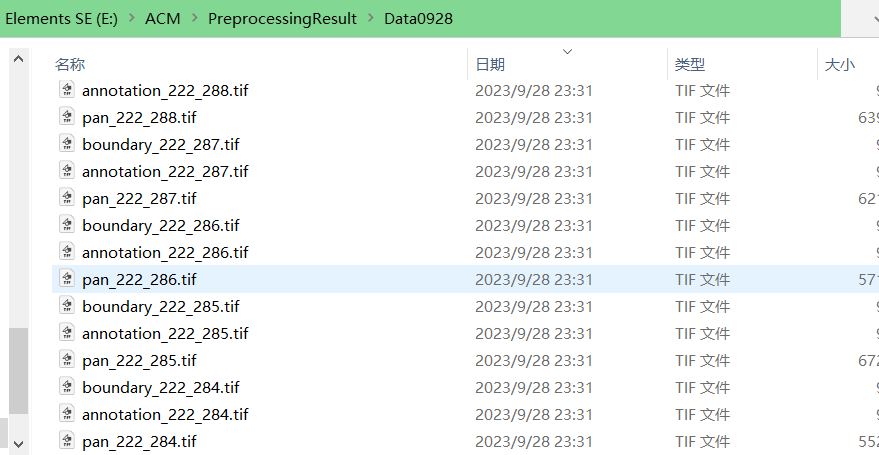
output file example